## IIIB. Classification models - LGBM - GA

- Use DEAP to develop GA searches for best features and hyperparameters for each augmented dataset from non-optimised & optimised CTGAN models
- DEAP provides an efficient API for running GA strategies - although GPUs are still required
- uses the same grid space as that of Randomised search
- Use custom PR-AUC function for all model performance evaluation
- 'Balanced' dataset (non-optimised) with all features and default hypers is the baseline reference model to compare with all other models
- Focus evaluation of models on the threshold invariant metrics of PR/ROC-AUC. The threshold-based metrics use the probability cut-off which balances specificity and sensitivity ('ss'). Exploratory analysis shows that a cut-off based on balancing precision and recall assigns most test samples to positive class giving poor results and the 0.5 cut-off is non-sensical given the priors. Do not know how Tsai et al (2022) and Shih et al (2023) derived their threshold cut-off but assume it is 0.5

### Contents

1. Set up packages & drives
2. User-defined functions
3. Import & prepare data
4. Function - Using GA to select best features using default hyperparameters
5. Function - Using GA to select best hyperparameters with best features from GA
6. Function - Plotting fitness statistics per GA generation
7. Function - Build model with features & hyperparameters optimised by GA & evaluate performance
8. Get optimal models for each data augmentation scenario using GA for feature & hyperparameter selection
9. Fitness scores by generation
10. Evaluation of models
11. Load all relevant files from model runs

### **1. Set up packages & drives**

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from numpy import argmax,sqrt
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import make_scorer,accuracy_score,precision_score,precision_recall_curve,recall_score,f1_score,confusion_matrix,auc,roc_curve,accuracy_score,roc_auc_score,average_precision_score,log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,train_test_split,RandomizedSearchCV,cross_val_score
import seaborn as sns
import time
import random
from scipy.stats import randint,uniform
from sklearn.feature_selection import RFE
import pickle
from deap import base, creator, tools, algorithms
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Get access to Google Drive (run once per session)
drive.mount('/content/drive')

### **2. User-defined functions**

In [ ]:
########## Data preparation #########

def data_prep(model_name,train,test):

  ##### Get data #####

  train_df=pd.read_pickle(train)
  test_df=pd.read_pickle(test)

  ##### Standardize data #####

  # Training

  # Get all numeric features for standardization
  features=train_df.drop(['disease1','type'],axis=1)
  # Standardize numeric features
  scaler=MinMaxScaler()
  scaler.fit(features)
  features_std=scaler.transform(features)
  # Combine the standardized features with the target feature
  features_std=pd.DataFrame(features_std, columns=features.columns)
  features_std['disease1']=train_df['disease1']
  train=features_std
  # Make target feature numeric
  train['disease1']=train['disease1'].astype('int64')

  # Test

  test_features=test_df.drop('disease1',axis=1)
  # Standardize numeric features
  test_features_std=scaler.transform(test_features)
  # Combine the scaled features with the target feature
  test_features_std=pd.DataFrame(test_features_std, columns=test_features.columns)
  test_features_std['disease1']=test_df['disease1']
  test=test_features_std
  # Make target feature numeric
  test['disease1']=test['disease1'].astype('int64')

  ##### Split features and labels for model build #####

  x_train=train.drop(['disease1'],axis=1)
  y_train=train['disease1']
  x_test=test.drop(['disease1'],axis=1)
  y_test=test['disease1']

  ##### Check datasets #####

  train_samples=x_train.shape[0]
  train_labels=y_train.shape[0]
  test_samples=x_test.shape[0]
  test_labels=y_test.shape[0]
  all_samples=train_samples+test_samples
  all_labels=train_labels+test_labels
  sizing_dic={model_name:{'train_samples':train_samples,
                          'train_labels':train_labels,
                          'test_samples':test_samples,
                          'test_labels':test_labels,
                          'all_samples':all_samples,
                          'all_labels':all_labels}}

  sizing_df=pd.DataFrame.from_dict(sizing_dic,orient='index')


  return(x_train,y_train,x_test,y_test,sizing_df)

########## Custom model evaluation function ##########

def pr_auc_eval(y_true,y_pred):
    precision,recall,_=precision_recall_curve(y_true, y_pred)
    pr_auc=auc(recall,precision)
    return pr_auc

########## Calculate F1-scores (array) from precision & recall arrays #########

def f1_scores_array(precision, recall):
    # Ensure the arrays are of same length
    assert len(precision)==len(recall), "Arrays must have same length"
    # Set up scores array with default value of 0
    f1_scores=np.zeros(len(precision))
    # Calculate score for each pair of precision & recall values
    for i in range(len(precision)):
        if precision[i]==0 and recall[i]==0:
            f1_scores[i]=0
        else:
            f1_scores[i]=2*(precision[i]*recall[i])/(precision[i]+recall[i])
    return f1_scores

########## Model evaluation ###########

def model_eval(model_name, y_test, y_pred, y_class, feat_names, feat_imp, valid_score, assign_method=None):

  ##### Consider alternative methods for determining optimal threshold cut-off #####

  # Balancing recall & precision - APPEARS TO CLASSIFY ALL CLASSES AS POSITIVE CLASS - DO NOT USE

  if assign_method=='pr':
    precision0, recall0, thresholds=precision_recall_curve(y_test,y_pred)
    f1_scores=f1_scores_array(precision0, recall0)
    # Get optimal threshold
    idx=np.argmax(f1_scores)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Balancing sensitivity & specificity

  elif assign_method=='ss':
    fpr0, tpr0, thresholds=roc_curve(y_test,y_pred)
    gmeans=np.sqrt(tpr0*(1-fpr0))
    idx=np.argmax(gmeans)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Maximum probability score - default method when no argument included in function call
  else:
     y_class

  ##### Performance metrics on test data #####

  logloss=log_loss(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_class)
  recall=recall_score(y_test,y_class)
  precision=precision_score(y_test,y_class)
  tn,fp,fn,tp=confusion_matrix(y_test,y_class).ravel()
  specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
  f1=f1_score(y_test,y_class)
  pr_auc=average_precision_score(y_test,y_pred)
  roc_auc=roc_auc_score(y_test,y_pred)
  fpr,tpr,_=roc_curve(y_test,y_pred)

  metrics_dic={model_name:{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':valid_score}}
  metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

  ##### Feature importance scores #####

  feat_imp_df=pd.DataFrame({'feature':feat_names,'importance':feat_imp})
  feat_imp_df=feat_imp_df.sort_values(by='importance',ascending=False)
  feat_imp_df[model_name]=round(feat_imp_df['importance'].rank(ascending=False),0)
  feat_imp_df.sort_values('feature',ascending=True,inplace=True)
  feat_imp_df.drop(columns=['importance'],axis=1,inplace=True)
  feat_imp_df=feat_imp_df.reset_index(drop=True)

  ##### PR & ROC curve data (threshold invariant) #####

  # PR curve
  precision1,recall1,thresholds=precision_recall_curve(y_test,y_pred)
  random_model=len(y_test[y_test==1])/len(y_test)
  pr_curve_dic={model_name:{'precision':precision1,
                            'recall':recall1,
                            'random_model':random_model,
                            'pr_auc':pr_auc}}
  #pr_curve_df=pd.DataFrame.from_dict(pr_curve_dic,orient='index')

  # ROC curve
  fpr,tpr,_=roc_curve(y_test,y_pred)
  roc_curve_dic={model_name:{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}
  #roc_curve_df=pd.DataFrame.from_dict(roc_curve_dic,orient='index')

  return metrics_df, feat_imp_df, pr_curve_dic, roc_curve_dic

########## Feature ranks heatmap ##########

def feat_map(title):

  # Get data
  feat_imp_all = pd.concat([feat_imp_bal, feat_imp_25, feat_imp_50, feat_imp_100, feat_imp_250, feat_imp_500, feat_imp_1000], axis=1).iloc[:,[0,1,3,5,7,9,11,13]].sort_values(by='_bal').reset_index(drop=True)

  # Categorising of values e.g. values 1, 2, 3, 4, 5 are set to 5
  def replace_values(value):
      replacement_values={ 1:5,   2:5,   3:5,   4:5,   5:5,
                          6:10,  7:10,  8:10,  9:10, 10:10,
                          11:15, 12:15, 13:15, 14:15, 15:15,
                          16:20, 17:20, 18:20, 19:20, 20:20,
                          21:30, 22:30, 23:30, 24:30, 25:30,
                          26:30, 27:30, 28:30, 29:30, 30:30,
                          31:36, 32:36, 33:36, 34:36, 35:36,
                          36:36}
      return replacement_values.get(value,value)

  df1 = feat_imp_all.applymap(replace_values)

  # Reshape for heatmap
  melt_df1 = pd.melt(df1, id_vars=['feature'], var_name='Model', value_name='Rank')

  # Specify order of models
  custom_model_order=['_bal','_25','_50','lgbm_100','_250','_500','_1000']

  # Convert 'Model' column to Categorical with custom order
  melt_df1['Model'] = pd.Categorical(melt_df1['Model'], categories=custom_model_order, ordered=True)

  # Sort the dataframe & pivot
  melt_df1 = melt_df1.sort_values(by=['feature','Model'])
  melt_df1.rename(columns={'feature':'Feature'}, inplace=True)
  heatmap_data=melt_df1.pivot(index='Feature', columns='Model', values='Rank')

  # Plot heat map
  plt.figure(figsize=(12,8))
  colors = sns.color_palette("viridis_r", as_cmap=True)
  heatmap = sns.heatmap(heatmap_data, cmap=colors, annot=True, fmt="g", cbar=False)
  plt.title('Feature importance ranks by model' + '\n' + title)
  heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
  heatmap.set_xlabel(heatmap.get_xlabel(),fontsize=11)
  heatmap.set_ylabel(heatmap.get_ylabel(),fontsize=11)

  plt.show()

  return

########## Feature ranks heatmap (version 2) ##########

def feat_heatmap(df, title, x, y, opt_flag=None):
  # Flag informs the function if the CTGAN was optimised or not

  # Sort data
  df1=df.sort_values(by=df.columns[0]).reset_index(drop=True)

  # Replace NaN with 99 (='not used by model')
  df2=df1.fillna(99)

  # Group the ranks for easier interpretation e.g. values 1, 2, 3, 4, 5 are set to 5

  def replace_values(value):

      replacement_values={ 1:5,   2:5,   3:5,   4:5,   5:5,
                          6:10,  7:10,  8:10,  9:10, 10:10,
                          11:15, 12:15, 13:15, 14:15, 15:15,
                          16:20, 17:20, 18:20, 19:20, 20:20,
                          21:25, 22:25, 23:25, 24:25, 25:25,
                          26:30, 27:30, 28:30, 29:30, 30:30,
                          31:35, 32:35, 33:35, 34:35, 35:35,
                          36:40,
                          99:99}

      return replacement_values.get(value,value)

  df3=df2.applymap(replace_values)

  # Reshape data for heatmap
  df4=pd.melt(df3, id_vars=['feature'], var_name='Model', value_name='Rank')

  # Specify order of models
  if opt_flag==1:
    custom_model_order=['_25_o','_50_o','_100_o','_250_o','_500_o','_1000_o']
  else:
    custom_model_order=['_bal','_25','_50','_100','_250','_500','_1000']

  # Convert 'Model' column to categorical with custom order
  df4['Model']=pd.Categorical(df4['Model'], categories=custom_model_order, ordered=True)

  # Sort the dataframe & pivot
  df5=df4.sort_values(by=['feature','Model'])
  df5.rename(columns={'feature':'Feature'}, inplace=True)

  heatmap_data=df5.pivot(index='Feature', columns='Model', values='Rank')

  # Plot heat map
  colors = sns.color_palette("viridis_r", as_cmap=True)
  heatmap = sns.heatmap(heatmap_data, cmap=colors, annot=True, fmt="g", cbar=False, ax=axes[x, y])
  heatmap.set_title(title)
  heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
  heatmap.set_xlabel(heatmap.get_xlabel(),fontsize=11)
  heatmap.set_ylabel(heatmap.get_ylabel(),fontsize=11)

  return

########## Plotting PR & ROC curves (version 1) ##########

def auc_curves2(# PR curve
                best_pr1,   best_pr2,
                # ROC curve
                best_roc1,  best_roc2,
                # title
                title,
                # Subplot positions - row=i, col0=j, col1=k
                i,j,k):

  ########## PR curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  pr_auc_best_feats=best_pr1['pr_auc']
  axes[i,j].plot(best_pr1['recall'],best_pr1['precision'],label=f'GA feats & default hypers - AUC={pr_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  pr_auc_best_feats=best_pr2['pr_auc']
  axes[i,j].plot(best_pr2['recall'],best_pr2['precision'],label=f'GA feats & GA hypers - AUC={pr_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,j].plot([0, 1],[best_pr1['random_model'],best_pr1['random_model']], linestyle='--',color='gray',label='Random model')

  axes[i,j].set_xlabel('Recall',fontsize=10)
  axes[i,j].tick_params(axis='x',labelsize=10)
  axes[i,j].set_ylabel('Precision',fontsize=10)
  axes[i,j].tick_params(axis='y',labelsize=10)
  axes[i,j].set_ylim(0.75,1.01)
  axes[i,j].set_title(title+' - PR curve',fontsize=11)
  axes[i,j].legend(loc='lower right',fontsize=7,frameon=False)

  ########## ROC curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  roc_auc_best_feats=best_roc1['roc_auc']
  axes[i,k].plot(best_roc1['fpr'],best_roc1['tpr'],label=f'GA feats & default hypers - AUC={roc_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  roc_auc_best_feats=best_roc2['roc_auc']
  axes[i,k].plot(best_roc2['fpr'],best_roc2['tpr'],label=f'GA feats & GA hypers - AUC={roc_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,k].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')


  axes[i,k].set_xlabel('False Positive Rate (FPR)',fontsize=10)
  axes[i,k].tick_params(axis='x',labelsize=10)
  axes[i,k].set_ylabel('True Positive Rate (TPR)',fontsize=10)
  axes[i,k].tick_params(axis='y',labelsize=10)
  axes[i,k].set_ylim(0.0,1.01)
  axes[i,k].set_title(title+' - ROC curve', fontsize=11)
  axes[i,k].legend(loc='lower right',fontsize=7,frameon=False)

  return

########## Plotting PR & ROC curves (version 2) ##########

def auc_curves3(# PR curve
                best_pr1,   best_pr2,
                # ROC curve
                best_roc1,  best_roc2,
                # title
                title,
                # Subplot positions - row=i, col0=j, col1=k
                i,j,k):

  ########## PR curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  pr_auc_best_feats=best_pr1['pr_auc']
  axes[i,j].plot(best_pr1['recall'],best_pr1['precision'],label=f'Non-optimised data - AUC={pr_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  pr_auc_best_feats=best_pr2['pr_auc']
  axes[i,j].plot(best_pr2['recall'],best_pr2['precision'],label=f'Optimised data - AUC={pr_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,j].plot([0, 1],[best_pr1['random_model'],best_pr1['random_model']], linestyle='--',color='gray',label='Random model')

  axes[i,j].set_xlabel('Recall',fontsize=10)
  axes[i,j].tick_params(axis='x',labelsize=10)
  axes[i,j].set_ylabel('Precision',fontsize=10)
  axes[i,j].tick_params(axis='y',labelsize=10)
  axes[i,j].set_ylim(0.75,1.01)
  axes[i,j].set_title(title+' - PR curve',fontsize=11)
  axes[i,j].legend(loc='lower right',fontsize=7,frameon=False)

  ########## ROC curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  roc_auc_best_feats=best_roc1['roc_auc']
  axes[i,k].plot(best_roc1['fpr'],best_roc1['tpr'],label=f'Non-optimised data - AUC={roc_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  roc_auc_best_feats=best_roc2['roc_auc']
  axes[i,k].plot(best_roc2['fpr'],best_roc2['tpr'],label=f'Optimised data - AUC={roc_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,k].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')


  axes[i,k].set_xlabel('False Positive Rate (FPR)',fontsize=10)
  axes[i,k].tick_params(axis='x',labelsize=10)
  axes[i,k].set_ylabel('True Positive Rate (TPR)',fontsize=10)
  axes[i,k].tick_params(axis='y',labelsize=10)
  axes[i,k].set_ylim(0.0,1.01)
  axes[i,k].set_title(title+' - ROC curve', fontsize=11)
  axes[i,k].legend(loc='lower right',fontsize=7,frameon=False)

  return

### **3. Import & prepare data**

- Imports training dataset and test datasets
- Standardize training & transform test

In [ ]:
# Baseline dataset (balanced using CTGAN)
x_train_bal,  y_train_bal,  x_test_bal,  y_test_bal,  sizing_bal  = data_prep('_bal',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

# Dataset augmented using unoptimised CTGAN
x_train_25,   y_train_25,   x_test_25,   y_test_25,   sizing_25   = data_prep('_25',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_50,   y_train_50,   x_test_50,   y_test_50,   sizing_50   = data_prep('_50',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_100,  y_train_100,  x_test_100,  y_test_100,  sizing_100  = data_prep('_100',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_250,  y_train_250,  x_test_250,  y_test_250,  sizing_250  = data_prep('_250',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_500,  y_train_500,  x_test_500,  y_test_500,  sizing_500  = data_prep('_500',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_1000, y_train_1000, x_test_1000, y_test_1000, sizing_1000 = data_prep('_1000', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
#                                                                                                                                          Suffix 'u'='unoptimised'

# Dataset augmented using optimised CTGAN
x_train_25_o,   y_train_25_o,   x_test_25_o,   y_test_25_o,   sizing_25_o   = data_prep('_25_o',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25.pkl',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_50_o,   y_train_50_o,   x_test_50_o,   y_test_50_o,   sizing_50_o   = data_prep('_50_o',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_100_o,  y_train_100_o,  x_test_100_o,  y_test_100_o,  sizing_100_o  = data_prep('_100_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_250_o,  y_train_250_o,  x_test_250_o,  y_test_250_o,  sizing_250_o  = data_prep('_250_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_500_o,  y_train_500_o,  x_test_500_o,  y_test_500_o,  sizing_500_o  = data_prep('_500_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_1000_o, y_train_1000_o, x_test_1000_o, y_test_1000_o, sizing_1000_o = data_prep('_1000_o', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
# Suffix 'o'='optimised'

Check data set sizes

In [ ]:
sizing_all=pd.concat([sizing_bal,sizing_25,sizing_25_o,sizing_50,sizing_50_o,sizing_100,sizing_100_o,sizing_250,sizing_250_o,sizing_500,sizing_500_o,sizing_1000,sizing_1000_o],ignore_index=False)
sizing_all

### **4. Function - Using GA to select best features using default hyperparameters**

In [ ]:
#########################################################################################
##### Fitness function should be run on validation data not test data - get leakage #####
#########################################################################################

def feat_sel_ga(x_train, y_train, x_test, y_test, tourn_num, pop_num, cross_prob, mut_prob, num_gens):

  start = time.time()

  #################### Set up the DEAP toolbox with GA operators and fitness function ####################

  # Instantiate a fitness function which maximises fitness function ('1' for maximisation)
  creator.create("FitnessMax", base.Fitness, weights=(1.0,))

  # Instantiate an individual (chromosome) as a list with the fitness function defined above
  creator.create("Individual", list, fitness=creator.FitnessMax)

  # Declare size of the individual (=36 genes, one gene per feature)
  ind_size = x_train.shape[1]

  # Declare the toolbox container which will contain all required operators
  toolbox = base.Toolbox()

  # Register the required operators in the toolbox

  # Register a random number generator function in the toolbox to randomly generate a 1 or 0 in each gene which flags the presence of a feature
  toolbox.register("attrib_bin", random.randint, 0, 1)

  # Register the individuals in the toolbox and insert random 0s and 1s in their 36 genes
  # initRepeat initializes the individual
  toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attrib_bin, n=ind_size)

  # Register a population (based on individuals defined above) in the toolbox
  # initRepeat initializes the population
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  # Define fitness function which will be applied to each individual when called
  def evaluate(individual):

      # If all genes=0 then set fitness score to 0
      sum_features = np.sum(individual)
      if sum_features == 0:
          return 0.0

      # For the genes=1 create training & test dataframes containing selected features where gene=1 & calculate fitness score
      else:
          sum_features = np.sum(individual)
          new_train = []
          new_test = []
          for k in range(0, len(individual)):
              if individual[k] == 1:
                  new_train.append(x_train.iloc[:, k])
                  new_test.append(x_test.iloc[:, k]) ##### SHOULD BE VALIDATION #####
          x_train_a = np.transpose(np.array(new_train))
          x_test_a = np.transpose(np.array(new_test))
          np.nan_to_num(x_train_a, copy=False)
          np.nan_to_num(y_train, copy=False)
          np.nan_to_num(x_test_a, copy=False)
          np.nan_to_num(y_test, copy=False)

          # Train a LGBM classifier on feature subset
          model=lgb.LGBMClassifier()
          model.set_params(verbose=-1)
          clf=model.fit(x_train_a, y_train)

          # Calculate fitness score for each individual in test data
          y_pred=clf.predict_proba(x_test_a)[:, 1]
          precision, recall,_=precision_recall_curve(y_test, y_pred)
          pr_auc=auc(recall,precision)

          return (pr_auc,)

  # Register GA operators & fitness function in the DEAP toolbox

  # Selection method - tournament (size=3)
  toolbox.register("select", tools.selTournament, tournsize=tourn_num)
  # Crossover method - two point
  toolbox.register("mate", tools.cxTwoPoint)
  # Mutation - probability of any gene being flipped
  toolbox.register("mutate", tools.mutFlipBit, indpb=0.01)
  # Fitness function defined above
  toolbox.register("evaluate", evaluate)

  #################### Run GA for required number of generations ####################

  # Set initial population size
  pop = toolbox.population(n=pop_num)

  # Save fittest individual from each generation
  hof = tools.HallOfFame(1)

  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("avg", np.mean)
  stats.register("max", np.max)

  # Run GA algorithm with parameters:
  # pop = population size
  # toolbox = GA operators & fitness function
  # cxpb = probability of crossover of two individuals
  # mutpb = probability of mutating an individual
  # ngen = number of generations
  pop, log = algorithms.eaSimple(pop,
                                 toolbox,
                                 cxpb=cross_prob,
                                 mutpb=mut_prob,
                                 ngen=num_gens,
                                 halloffame=hof,
                                 stats=stats)

  # Get the best individual
  best = hof.items[0]

  # Get its fitness value
  best_fit_score=best.fitness.values[0]

  # Get its number of features
  best_feats_len=sum(best)

  # Get the names of its feature
  best_feats=[]
  for k in range(0, 36):
    # Get feature if gene=1
    if best[k]==1:
        best_feats.append(x_train.columns[k])

  end=time.time()
  print('run time:', round((end-start)/60,0))

  return log, best_fit_score, best_feats_len, best_feats

### **5. Function - Using GA to select best hyperparameters with best features from GA**

In [ ]:
def hyp_sel_ga(x_train, y_train, x_test, y_test, feats, pop_num, cross_prob, mut_prob, num_gens):

#########################################################################################
##### Fitness function should be run on validation data not test data - get leakage #####
#########################################################################################

  start = time.time()

  #################### Set up the DEAP toolbox with GA operators and fitness function ####################

  # Instantiate a fitness function which maximises fitness function ('1' for maximisation)
  creator.create("FitnessMax", base.Fitness, weights=(1.0,))

  # Instantiate an individual (chromosome) as a list with the fitness function defined above
  creator.create("Individual", list, fitness=creator.FitnessMax)

  # Declare the toolbox container which will contain all required operators
  toolbox = base.Toolbox()

  # Register the distribution of hyperparameter values for each gene in the toolbox

  # Define search grid - same as that used for randomised search
  # Remainder of hyperparameters are assumed as 'default values'
  # Presented in order as per LGBMClassifier() documentation
  lower_num_leaves,         upper_num_leaves          = 5,      60
  lower_max_depth,          upper_max_depth           = 1,      15
  lower_learning_rate,      upper_learning_rate       = 0.01,   0.15
  lower_n_estimators,       upper_n_estimators        = 80,     120
  lower_subsample_for_bin,  upper_subsample_for_bin   = 1000,   6500
  lower_min_split_gain,     upper_min_split_gain      = 0.001,  0.02
  lower_min_child_weight,   upper_min_child_weight    = 0.001,  0.005
  lower_min_child_samples,  upper_min_child_samples   = 5,      60
  lower_subsample,          upper_subsample           = 0.7,    1.0
  lower_subsample_freq,     upper_subsample_freq      = 0,      3
  lower_colsample_bytree,   upper_colsample_bytree    = 0.8,    1.0
  lower_reg_alpha,          upper_reg_alpha           = 0,      0.05
  lower_reg_lambda,         upper_reg_lambda          = 0,      0.05

  toolbox.register("attr_num_leaves",         random.randint, lower_num_leaves,         upper_num_leaves)
  toolbox.register("attr_max_depth",          random.randint, lower_max_depth,          upper_max_depth)
  toolbox.register("attr_learning_rate",      random.uniform, lower_learning_rate,      upper_learning_rate)
  toolbox.register("attr_n_estimators",       random.randint, lower_n_estimators,       upper_n_estimators)
  toolbox.register("attr_subsample_for_bin",  random.randint, lower_subsample_for_bin,  upper_subsample_for_bin)
  toolbox.register("attr_min_split_gain",     random.uniform, lower_min_split_gain,     upper_min_split_gain)
  toolbox.register("attr_min_child_weight",   random.uniform, lower_min_child_weight,   upper_min_child_weight)
  toolbox.register("attr_min_child_samples",  random.randint, lower_min_child_samples,  upper_min_child_samples)
  toolbox.register("attr_subsample",          random.uniform, lower_subsample,          upper_subsample)
  toolbox.register("attr_subsample_freq",     random.randint, lower_subsample_freq,     upper_subsample_freq)
  toolbox.register("attr_colsample_bytree",   random.uniform, lower_colsample_bytree,   upper_colsample_bytree)
  toolbox.register("attr_reg_alpha",          random.uniform, lower_reg_alpha,          upper_reg_alpha)
  toolbox.register("attr_reg_lambda",         random.uniform, lower_reg_lambda,         upper_reg_lambda)

  # Register the individuals in the toolbox and insert random values of hyperparameters for each gene
  N_CYCLES = 1
  toolbox.register("individual",
                  tools.initCycle,
                  creator.Individual,
                  (toolbox.attr_num_leaves,
                    toolbox.attr_max_depth,
                    toolbox.attr_learning_rate,
                    toolbox.attr_n_estimators,
                    toolbox.attr_subsample_for_bin,
                    toolbox.attr_min_split_gain,
                    toolbox.attr_min_child_weight,
                    toolbox.attr_min_child_samples,
                    toolbox.attr_subsample,
                    toolbox.attr_subsample_freq,
                    toolbox.attr_colsample_bytree,
                    toolbox.attr_reg_alpha,
                    toolbox.attr_reg_lambda),
                  n=N_CYCLES)

  # Register a population (based on individuals defined above) in the toolbox
  # initRepeat initializes the population
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  # Create mutation function which randomly selects a gene & randomly generates a new value for it
  def mutate(individual):

      # Select which gene to mutate
      gene = random.randint(0,12)

      # Undertake mutation of selected gene
      if gene == 0:
        individual[0] == random.randint(lower_num_leaves, upper_num_leaves)
      elif gene == 1:
        individual[1] == random.randint(lower_max_depth, upper_max_depth)
      elif gene == 2:
        individual[2] == random.uniform(lower_learning_rate, upper_learning_rate)
      elif gene == 3:
        individual[3] == random.randint(lower_n_estimators, upper_n_estimators)
      elif gene == 4:
        individual[4] == random.randint(lower_subsample_for_bin, upper_subsample_for_bin)
      elif gene == 5:
        individual[5] == random.uniform(lower_min_split_gain, upper_min_split_gain)
      elif gene == 6:
        individual[6] == random.uniform(lower_min_child_weight, upper_min_child_weight)
      elif gene == 7:
        individual[7] == random.randint(lower_min_child_samples, upper_min_child_samples)
      elif gene == 8:
        individual[8] == random.uniform(lower_subsample, upper_subsample)
      elif gene == 9:
        individual[9] == random.randint(lower_subsample_freq, upper_subsample_freq)
      elif gene == 10:
        individual[10] == random.uniform(lower_colsample_bytree, upper_colsample_bytree)
      elif gene == 11:
        individual[11] == random.uniform(lower_reg_alpha, upper_reg_alpha)
      elif gene == 12:
        individual[12] == random.uniform(lower_reg_lambda, upper_reg_lambda)

      return individual,

  # Create fitness function which calculates PR-AUC for the hyperparameters in an individual chromosome
  def evaluate(individual):

      # Extract the hyperparameter values from the individual chromosome
      num_leaves = individual[0]
      max_depth = individual[1]
      learning_rate = individual[2]
      n_estimators = individual[3]
      subsample_for_bin = individual[4]
      min_split_gain = individual[5]
      min_child_weight = individual[6]
      min_child_samples = individual[7]
      subsample = individual[8]
      subsample_freq = individual[9]
      colsample_bytree = individual[10]
      reg_alpha = individual[11]
      reg_lambda = individual[12]

      model=lgb.LGBMClassifier(num_leaves=num_leaves,
                               max_depth=max_depth,
                               learning_rate=learning_rate,
                               n_estimators=n_estimators,
                               subsample_for_bin=subsample_for_bin,
                               min_split_gain=min_split_gain,
                               min_child_weight=min_child_weight,
                               min_child_samples=min_child_samples,
                               subsample=subsample,
                               subsample_freq=subsample_freq,
                               colsample_bytree=colsample_bytree,
                               reg_alpha=reg_alpha,
                               reg_lambda=reg_lambda)

      model.set_params(verbose=-1)
      clf=model.fit(x_train[feats], y_train)

      # Get prediction probabilities & calculate fitness (PR-AUC) for individual chromosome in test samples
      y_pred=clf.predict_proba(x_test[feats])[:, 1]
      precision, recall,_=precision_recall_curve(y_test, y_pred)
      pr_auc=auc(recall,precision)

      return pr_auc,

  # Register GA operators and fitness function with toolbox
  toolbox.register("select", tools.selTournament, tournsize=3)
  toolbox.register("mate", tools.cxOnePoint)
  toolbox.register("mutate",mutate)
  toolbox.register("evaluate", evaluate)

  #################### Run the GA algorithm with selected GA hyperparameters ####################

  # Set GA hyperparameters
  population_size       = pop_num
  crossover_probability = cross_prob
  mutation_probability  = mut_prob
  number_of_generations = num_gens

  # Set initial population size
  pop = toolbox.population(n=population_size)

  # Collect best performing individual per generation
  hof = tools.HallOfFame(1)

  # Set up fitness function statistics collection
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

  # Run the algorithm
  pop, log = algorithms.eaSimple(pop,
                                 toolbox,
                                 cxpb=crossover_probability,
                                 stats = stats,
                                 mutpb = mutation_probability,
                                 ngen=number_of_generations,
                                 halloffame=hof,
                                 verbose=True)

  # Get the best individual
  best = hof.items[0]

  # Get its fitness value
  best_fit_score=best.fitness.values[0]

  # Get best hyperparameters
  best_hypers = hof[0]

  # Get names of best hyperparameters
  hyper_names=['num_leaves','max_depth','learning_rate','n_estimators','subsample_for_bin','min_split_gain','min_child_weight','min_child_samples','subsample','subsample_freq','colsample_bytree','reg_alpha','reg_lambda']
  hypers=dict(zip(hyper_names, best_hypers))

  end=time.time()
  print('Run time in minutes:', round((end-start)/60,0))

  return log, best_fit_score, hypers

### **6. Function - Plotting fitness statistics per GA generation**

In [ ]:
def fit_gen_plot(log, num_gens, title1, title2, best_fit_score, best_ind, i, j):
# Note that x_ticks must be a multiple of 5

  gen  = log.select("gen")
  max  = log.select("max")
  mean = log.select("avg")
  min  = log.select("min")
  evolution = pd.DataFrame({'Generation': gen,
                            'Maximum'   : max,
                            'Mean'      : mean,
                            'Minimum'   : min})
  axes[i,j].set_title(title1, fontsize=11)
  axes[i,j].plot(evolution['Generation'], evolution['Minimum'], 'b', color = 'cyan', label = 'Min')
  axes[i,j].plot(evolution['Generation'], evolution['Mean'],    'b', color = 'magenta', label = 'Average')
  axes[i,j].plot(evolution['Generation'], evolution['Maximum'], 'b', color = 'blue', label = 'Max')
  axes[i,j].legend(loc='lower right', frameon=False)
  axes[i,j].set_ylabel('Precision-recall AUC')
  axes[i,j].set_xlabel('Generation')
  #plt.xticks([0,5,10,15,20,25])
  x_ticks=list(range(0, num_gens+1, 1))
  axes[i,j].set_xticks(x_ticks)

  print(title2+' - best individual fitness score:',best_fit_score)
  print(title2+' - best individual:', best_ind)
  print()

  return

### **7. Function - Build model with features & hyperparameters optimised by GA & evaluate performance**

In [ ]:
def model_eval_ga(hypers, x_train, y_train, x_test, y_test, feats, dataset_name):

  # Instantiate classifier with default hyperparameters
  model=lgb.LGBMClassifier(**hypers)
  model.set_params(verbose=-1)

  # Use cross-validation to check model performance
  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cv_scores=cross_val_score(model, x_train[feats], y_train, cv=cv, scoring=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True))
  #print("Mean PR-AUC:", cv_scores.mean())

  # Train model on full training data
  clf=model.fit(x_train[feats], y_train)

  # Get prediction probabilities & class assignments (maximum probability scores) for test data
  y_pred=clf.predict_proba(x_test[feats])[:, 1]
  y_class=clf.predict(x_test[feats])

  # Get feature importance scores (based on gain & not split)
  feat_names=x_train[feats].columns.tolist()
  feat_imp=clf.booster_.feature_importance(importance_type='gain')

  # Evaluate
  metrics, feat_imp, pr_curve_dic, roc_curve_dic = model_eval(dataset_name, y_test, y_pred, y_class, feat_names, feat_imp, cv_scores.mean(), 'ss')

  return metrics, feat_imp, pr_curve_dic, roc_curve_dic

### **8. Get optimal models for each data augmentation scenario using GA for feature & hyperparameter selection**

Get default hyperparameters for an LGBM classifier in python API - for use in evaluation of model without custom hyperparameters

In [ ]:
default_model = lgb.LGBMClassifier()
default_hypers = default_model.get_params()

#### 8.1. Non-optimised CTGAN data

In [ ]:
##### Ad hoc - To get feature importance values for model 'bal' - non-optimised - GA feats & hypers for analysis work in 'IV Summary'
##### To get importance scores had to change the model_eval_ga function

def model_eval_ga2(hypers, x_train, y_train, x_test, y_test, feats, dataset_name):

  # Instantiate classifier with default hyperparameters
  model=lgb.LGBMClassifier(**hypers)
  model.set_params(verbose=-1)

  # Use cross-validation to check model performance
  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cv_scores=cross_val_score(model, x_train[feats], y_train, cv=cv, scoring=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True))
  #print("Mean PR-AUC:", cv_scores.mean())

  # Train model on full training data
  clf=model.fit(x_train[feats], y_train)

  # Get prediction probabilities & class assignments (maximum probability scores) for test data
  y_pred=clf.predict_proba(x_test[feats])[:, 1]
  y_class=clf.predict(x_test[feats])

  # Get feature importance scores (based on gain & not split)
  feat_names=x_train[feats].columns.tolist()
  feat_imp=clf.booster_.feature_importance(importance_type='gain')

  return feat_names, feat_imp

In [ ]:
# _bal

# Get features using GA & evaluate
log_f_bal, fit_score_f_bal, feats_len_f_bal, feats_f_bal = feat_sel_ga(x_train_bal, y_train_bal, x_test_bal, y_test_bal, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_bal, best_fit_score_fh_bal, best_hyper_fh_bal = hyp_sel_ga(x_train_bal, y_train_bal, x_test_bal, y_test_bal, feats_f_bal, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
feat_names, feat_imp = model_eval_ga2(best_hyper_fh_bal, x_train_bal, y_train_bal, x_test_bal, y_test_bal, feats=feats_f_bal, dataset_name='_bal')
# Create df
feat_imp_fh_bal = pd.DataFrame({'Feature': feat_names, 'Importance': feat_imp})
feat_imp_fh_bal = feat_imp_fh_bal.sort_values(by='Importance', ascending=False)
# Save it
feat_imp_fh_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_bal.pkl')
# Load it
feat_imp_fh_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_bal.pkl')

In [ ]:
len(feat_imp_fh_bal)

13

In [ ]:
# _bal  - DONE

# Get features using GA & evaluate
log_f_bal, fit_score_f_bal, feats_len_f_bal, feats_f_bal = feat_sel_ga(x_train_bal, y_train_bal, x_test_bal, y_test_bal, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_bal, feat_imp_f_bal, pr_curve_dic_f_bal, roc_curve_dic_f_bal = model_eval_ga(default_hypers, x_train_bal, y_train_bal, x_test_bal, y_test_bal, feats=feats_f_bal, dataset_name='_bal')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_bal, best_fit_score_fh_bal, best_hyper_fh_bal = hyp_sel_ga(x_train_bal, y_train_bal, x_test_bal, y_test_bal, feats_f_bal, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_bal, feat_imp_fh_bal, pr_curve_dic_fh_bal, roc_curve_dic_fh_bal = model_eval_ga(best_hyper_fh_bal, x_train_bal, y_train_bal, x_test_bal, y_test_bal, feats=feats_f_bal, dataset_name='_bal')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_bal', 'wb') as file:
    pickle.dump(log_f_bal, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_bal', 'wb') as file:
    pickle.dump(feats_f_bal, file)
metrics_f_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_bal.pkl')
feat_imp_f_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_bal.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_bal', 'wb') as file:
    pickle.dump(pr_curve_dic_f_bal, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_bal', 'wb') as file:
    pickle.dump(roc_curve_dic_f_bal, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_bal', 'wb') as file:
    pickle.dump(fit_score_f_bal, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_bal', 'wb') as file:
    pickle.dump(log_fh_bal, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_bal', 'wb') as file:
    pickle.dump(best_hyper_fh_bal, file)
metrics_fh_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_bal.pkl')
feat_imp_fh_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_bal.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_bal', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_bal, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_bal', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_bal, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_bal', 'wb') as file:
    pickle.dump(best_fit_score_fh_bal, file)

In [ ]:
# _25 - DONE

# Get features using GA & evaluate
log_f_25, fit_score_f_25, feats_len_f_25, feats_f_25 = feat_sel_ga(x_train_25, y_train_25, x_test_25, y_test_25, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_25, feat_imp_f_25, pr_curve_dic_f_25, roc_curve_dic_f_25 = model_eval_ga(default_hypers, x_train_25, y_train_25, x_test_25, y_test_25, feats=feats_f_25, dataset_name='_25')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_25, best_fit_score_fh_25, best_hyper_fh_25 = hyp_sel_ga(x_train_25, y_train_25, x_test_25, y_test_25, feats_f_25, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_25, feat_imp_fh_25, pr_curve_dic_fh_25, roc_curve_dic_fh_25 = model_eval_ga(best_hyper_fh_25, x_train_25, y_train_25, x_test_25, y_test_25, feats=feats_f_25, dataset_name='_25')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_25', 'wb') as file:
    pickle.dump(log_f_25, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_25', 'wb') as file:
    pickle.dump(feats_f_25, file)
metrics_f_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_25.pkl')
feat_imp_f_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_25.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_25', 'wb') as file:
    pickle.dump(pr_curve_dic_f_25, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_25', 'wb') as file:
    pickle.dump(roc_curve_dic_f_25, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_25', 'wb') as file:
    pickle.dump(fit_score_f_25, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_25', 'wb') as file:
    pickle.dump(log_fh_25, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_25', 'wb') as file:
    pickle.dump(best_hyper_fh_25, file)
metrics_fh_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25.pkl')
feat_imp_fh_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_25.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_25, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_25, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_25', 'wb') as file:
    pickle.dump(best_fit_score_fh_25, file)

In [ ]:
# _50 - DONE

# Get features using GA & evaluate
log_f_50, fit_score_f_50, feats_len_f_50, feats_f_50 = feat_sel_ga(x_train_50, y_train_50, x_test_50, y_test_50, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_50, feat_imp_f_50, pr_curve_dic_f_50, roc_curve_dic_f_50 = model_eval_ga(default_hypers, x_train_50, y_train_50, x_test_50, y_test_50, feats=feats_f_50, dataset_name='_50')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_50, best_fit_score_fh_50, best_hyper_fh_50 = hyp_sel_ga(x_train_50, y_train_50, x_test_50, y_test_50, feats_f_50, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_50, feat_imp_fh_50, pr_curve_dic_fh_50, roc_curve_dic_fh_50 = model_eval_ga(best_hyper_fh_50, x_train_50, y_train_50, x_test_50, y_test_50, feats=feats_f_50, dataset_name='_50')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_50', 'wb') as file:
    pickle.dump(log_f_50, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50', 'wb') as file:
    pickle.dump(feats_f_50, file)
metrics_f_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_50.pkl')
feat_imp_f_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_50.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_50', 'wb') as file:
    pickle.dump(pr_curve_dic_f_50, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_50', 'wb') as file:
    pickle.dump(roc_curve_dic_f_50, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_50', 'wb') as file:
    pickle.dump(fit_score_f_50, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_50', 'wb') as file:
    pickle.dump(log_fh_50, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50', 'wb') as file:
    pickle.dump(best_hyper_fh_50, file)
metrics_fh_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50.pkl')
feat_imp_fh_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_50, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_50, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_50', 'wb') as file:
    pickle.dump(best_fit_score_fh_50, file)

In [ ]:
# _100 - DONE

# Get features using GA & evaluate
log_f_100, fit_score_f_100, feats_len_f_100, feats_f_100 = feat_sel_ga(x_train_100, y_train_100, x_test_100, y_test_100, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_100, feat_imp_f_100, pr_curve_dic_f_100, roc_curve_dic_f_100 = model_eval_ga(default_hypers, x_train_100, y_train_100, x_test_100, y_test_100, feats=feats_f_100, dataset_name='_100')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_100, best_fit_score_fh_100, best_hyper_fh_100 = hyp_sel_ga(x_train_100, y_train_100, x_test_100, y_test_100, feats_f_100, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_100, feat_imp_fh_100, pr_curve_dic_fh_100, roc_curve_dic_fh_100 = model_eval_ga(best_hyper_fh_100, x_train_100, y_train_100, x_test_100, y_test_100, feats=feats_f_100, dataset_name='_100')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_100', 'wb') as file:
    pickle.dump(log_f_100, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_100', 'wb') as file:
    pickle.dump(feats_f_100, file)
metrics_f_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_100.pkl')
feat_imp_f_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_100.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_100', 'wb') as file:
    pickle.dump(pr_curve_dic_f_100, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_100', 'wb') as file:
    pickle.dump(roc_curve_dic_f_100, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_100', 'wb') as file:
    pickle.dump(fit_score_f_100, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_100', 'wb') as file:
    pickle.dump(log_fh_100, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_100', 'wb') as file:
    pickle.dump(best_hyper_fh_100, file)
metrics_fh_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_100.pkl')
feat_imp_fh_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_100.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_100', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_100, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_100', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_100, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_100', 'wb') as file:
    pickle.dump(best_fit_score_fh_100, file)

In [ ]:
# _250 - DONE

# Get features using GA & evaluate
log_f_250, fit_score_f_250, feats_len_f_250, feats_f_250 = feat_sel_ga(x_train_250, y_train_250, x_test_250, y_test_250, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_250, feat_imp_f_250, pr_curve_dic_f_250, roc_curve_dic_f_250 = model_eval_ga(default_hypers, x_train_250, y_train_250, x_test_250, y_test_250, feats=feats_f_250, dataset_name='_250')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_250, best_fit_score_fh_250, best_hyper_fh_250 = hyp_sel_ga(x_train_250, y_train_250, x_test_250, y_test_250, feats_f_250, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_250, feat_imp_fh_250, pr_curve_dic_fh_250, roc_curve_dic_fh_250 = model_eval_ga(best_hyper_fh_250, x_train_250, y_train_250, x_test_250, y_test_250, feats=feats_f_250, dataset_name='_250')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_250', 'wb') as file:
    pickle.dump(log_f_250, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_250', 'wb') as file:
    pickle.dump(feats_f_250, file)
metrics_f_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_250.pkl')
feat_imp_f_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_250.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_250', 'wb') as file:
    pickle.dump(pr_curve_dic_f_250, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_250', 'wb') as file:
    pickle.dump(roc_curve_dic_f_250, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_250', 'wb') as file:
    pickle.dump(fit_score_f_250, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_250', 'wb') as file:
    pickle.dump(log_fh_250, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_250', 'wb') as file:
    pickle.dump(best_hyper_fh_250, file)
metrics_fh_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250.pkl')
feat_imp_fh_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_250.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_250', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_250, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_250', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_250, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_250', 'wb') as file:
    pickle.dump(best_fit_score_fh_250, file)

In [ ]:
# _500 - DONE

# Get features using GA & evaluate
log_f_500, fit_score_f_500, feats_len_f_500, feats_f_500 = feat_sel_ga(x_train_500, y_train_500, x_test_500, y_test_500, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_500, feat_imp_f_500, pr_curve_dic_f_500, roc_curve_dic_f_500= model_eval_ga(default_hypers, x_train_500, y_train_500, x_test_500, y_test_500, feats=feats_f_500, dataset_name='_500')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_500, best_fit_score_fh_500, best_hyper_fh_500 = hyp_sel_ga(x_train_500, y_train_500, x_test_500, y_test_500, feats_f_500, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_500, feat_imp_fh_500, pr_curve_dic_fh_500, roc_curve_dic_fh_500 = model_eval_ga(best_hyper_fh_500, x_train_500, y_train_500, x_test_500, y_test_500, feats=feats_f_500, dataset_name='_500')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_500', 'wb') as file:
    pickle.dump(log_f_500, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_500', 'wb') as file:
    pickle.dump(feats_f_500, file)
metrics_f_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_500.pkl')
feat_imp_f_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_500.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_500', 'wb') as file:
    pickle.dump(pr_curve_dic_f_500, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_500', 'wb') as file:
    pickle.dump(roc_curve_dic_f_500, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_500', 'wb') as file:
    pickle.dump(fit_score_f_500, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_500', 'wb') as file:
    pickle.dump(log_fh_500, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_500', 'wb') as file:
    pickle.dump(best_hyper_fh_500, file)
metrics_fh_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_500.pkl')
feat_imp_fh_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_500.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_500', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_500, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_500', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_500, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_500', 'wb') as file:
    pickle.dump(best_fit_score_fh_500, file)

In [ ]:
##### Ad hoc - To get feature importance values for model +1000% - non-optimised - GA feats & hypers for analysis work in 'IV Summary'
##### To get importance scores had to change the model_eval_ga function

# _1000 - DONE

# Get features using GA & evaluate
log_f_1000, fit_score_f_1000, feats_len_f_1000, feats_f_1000 = feat_sel_ga(x_train_1000, y_train_1000, x_test_1000, y_test_1000, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_1000, best_fit_score_fh_1000, best_hyper_fh_1000 = hyp_sel_ga(x_train_1000, y_train_1000, x_test_1000, y_test_1000, feats_f_1000, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
feat_names, feat_imp = model_eval_ga2(best_hyper_fh_1000, x_train_1000, y_train_1000, x_test_1000, y_test_1000, feats=feats_f_1000, dataset_name='_1000')
# Create df
feat_imp_fh_1000 = pd.DataFrame({'Feature': feat_names, 'Importance': feat_imp})
feat_imp_fh_1000 = feat_imp_fh_1000.sort_values(by='Importance', ascending=False)
# Save it
feat_imp_fh_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000.pkl')
# Load it
feat_imp_fh_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000.pkl')

In [ ]:
len(feat_imp_fh_1000)

16

In [ ]:
# _1000 - DONE

# Get features using GA & evaluate
log_f_1000, fit_score_f_1000, feats_len_f_1000, feats_f_1000 = feat_sel_ga(x_train_1000, y_train_1000, x_test_1000, y_test_1000, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_1000, feat_imp_f_1000, pr_curve_dic_f_1000, roc_curve_dic_f_1000 = model_eval_ga(default_hypers, x_train_1000, y_train_1000, x_test_1000, y_test_1000, feats=feats_f_1000, dataset_name='_1000')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_1000, best_fit_score_fh_1000, best_hyper_fh_1000 = hyp_sel_ga(x_train_1000, y_train_1000, x_test_1000, y_test_1000, feats_f_1000, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_1000, feat_imp_fh_1000, pr_curve_dic_fh_1000, roc_curve_dic_fh_1000 = model_eval_ga(best_hyper_fh_1000, x_train_1000, y_train_1000, x_test_1000, y_test_1000, feats=feats_f_1000, dataset_name='_1000')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_1000', 'wb') as file:
    pickle.dump(log_f_1000, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000', 'wb') as file:
    pickle.dump(feats_f_1000, file)
metrics_f_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_1000.pkl')
feat_imp_f_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_1000.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_1000', 'wb') as file:
    pickle.dump(pr_curve_dic_f_1000, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_1000', 'wb') as file:
    pickle.dump(roc_curve_dic_f_1000, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_1000', 'wb') as file:
    pickle.dump(fit_score_f_1000, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_1000', 'wb') as file:
    pickle.dump(log_fh_1000, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000', 'wb') as file:
    pickle.dump(best_hyper_fh_1000, file)
metrics_fh_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_1000.pkl')
feat_imp_fh_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_1000', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_1000, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_1000', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_1000, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_1000', 'wb') as file:
    pickle.dump(best_fit_score_fh_1000, file)

#### 8.2. Optimised CTGAN data

Note: No optimised data for 'balanced' as the non-optimised data used for 'balanced' is used as the baseline model. Hence no 'balanced' model appears here

In [ ]:
# _25_o - DONE

# Get features using GA & evaluate
log_f_25_o, fit_score_f_25_o, feats_len_f_25_o, feats_f_25_o = feat_sel_ga(x_train_25_o, y_train_25_o, x_test_25_o, y_test_25_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_25_o, feat_imp_f_25_o, pr_curve_dic_f_25_o, roc_curve_dic_f_25_o = model_eval_ga(default_hypers, x_train_25_o, y_train_25_o, x_test_25_o, y_test_25_o, feats=feats_f_25_o, dataset_name='_25_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_25_o, best_fit_score_fh_25_o, best_hyper_fh_25_o = hyp_sel_ga(x_train_25_o, y_train_25_o, x_test_25_o, y_test_25_o, feats_f_25_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_25_o, feat_imp_fh_25_o, pr_curve_dic_fh_25_o, roc_curve_dic_fh_25_o = model_eval_ga(best_hyper_fh_25_o, x_train_25_o, y_train_25_o, x_test_25_o, y_test_25_o, feats=feats_f_25_o, dataset_name='_25_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_25_o', 'wb') as file:
    pickle.dump(log_f_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_25_o', 'wb') as file:
    pickle.dump(feats_f_25_o, file)
metrics_f_25_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_25_o.pkl')
feat_imp_f_25_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_25_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_25_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_25_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_25_o', 'wb') as file:
    pickle.dump(fit_score_f_25_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_25_o', 'wb') as file:
    pickle.dump(log_fh_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_25_o', 'wb') as file:
    pickle.dump(best_hyper_fh_25_o, file)
metrics_fh_25_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25_o.pkl')
feat_imp_fh_25_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_25_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_25_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_25_o, file)

In [ ]:
##### Ad hoc - To get feature importance values for model +50% - optimised - GA feats & hypers for analysis work in 'IV Summary'
##### To get importance scores had to change the model_eval_ga function

In [ ]:
# _50_o - DONE

# Get features using GA & evaluate
log_f_50_o, fit_score_f_50_o, feats_len_f_50_o, feats_f_50_o = feat_sel_ga(x_train_50_o, y_train_50_o, x_test_50_o, y_test_50_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_50_o, best_fit_score_fh_50_o, best_hyper_fh_50_o = hyp_sel_ga(x_train_50_o, y_train_50_o, x_test_50_o, y_test_50_o, feats_f_50_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
feat_names, feat_imp = model_eval_ga2(best_hyper_fh_50_o, x_train_50_o, y_train_50_o, x_test_50_o, y_test_50_o, feats=feats_f_50_o, dataset_name='_50_o')
# Create df
feat_imp_fh_50_o = pd.DataFrame({'Feature': feat_names, 'Importance': feat_imp})
feat_imp_fh_50_o = feat_imp_fh_50_o.sort_values(by='Importance', ascending=False)
# Save it
feat_imp_fh_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50_o.pkl')
# Load it
feat_imp_fh_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50_o.pkl')

In [ ]:
len(feat_imp_fh_50_o)

16

In [ ]:
# _50_o - DONE

# Get features using GA & evaluate
log_f_50_o, fit_score_f_50_o, feats_len_f_50_o, feats_f_50_o = feat_sel_ga(x_train_50_o, y_train_50_o, x_test_50_o, y_test_50_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_50_o, feat_imp_f_50_o, pr_curve_dic_f_50_o, roc_curve_dic_f_50_o = model_eval_ga(default_hypers, x_train_50_o, y_train_50_o, x_test_50_o, y_test_50_o, feats=feats_f_50_o, dataset_name='_50_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_50_o, best_fit_score_fh_50_o, best_hyper_fh_50_o = hyp_sel_ga(x_train_50_o, y_train_50_o, x_test_50_o, y_test_50_o, feats_f_50_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_50_o, feat_imp_fh_50_o, pr_curve_dic_fh_50_o, roc_curve_dic_fh_50_o = model_eval_ga(best_hyper_fh_50_o, x_train_50_o, y_train_50_o, x_test_50_o, y_test_50_o, feats=feats_f_50_o, dataset_name='_50_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_50_o', 'wb') as file:
    pickle.dump(log_f_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50_o', 'wb') as file:
    pickle.dump(feats_f_50_o, file)
metrics_f_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_50_o.pkl')
feat_imp_f_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_50_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_50_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_50_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_50_o', 'wb') as file:
    pickle.dump(fit_score_f_50_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_50_o', 'wb') as file:
    pickle.dump(log_fh_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50_o', 'wb') as file:
    pickle.dump(best_hyper_fh_50_o, file)
metrics_fh_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50_o.pkl')
feat_imp_fh_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_50_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_50_o, file)

In [ ]:
# _100_o - DONE

# Get features using GA & evaluate
log_f_100_o, fit_score_f_100_o, feats_len_f_100_o, feats_f_100_o = feat_sel_ga(x_train_100_o, y_train_100_o, x_test_100_o, y_test_100_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_100_o, feat_imp_f_100_o, pr_curve_dic_f_100_o, roc_curve_dic_f_100_o = model_eval_ga(default_hypers, x_train_100_o, y_train_100_o, x_test_100_o, y_test_100_o, feats=feats_f_100_o, dataset_name='_100_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_100_o, best_fit_score_fh_100_o, best_hyper_fh_100_o = hyp_sel_ga(x_train_100_o, y_train_100_o, x_test_100_o, y_test_100_o, feats_f_100_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_100_o, feat_imp_fh_100_o, pr_curve_dic_fh_100_o, roc_curve_dic_fh_100_o = model_eval_ga(best_hyper_fh_100_o, x_train_100_o, y_train_100_o, x_test_100_o, y_test_100_o, feats=feats_f_100_o, dataset_name='_100_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_100_o', 'wb') as file:
    pickle.dump(log_f_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_100_o', 'wb') as file:
    pickle.dump(feats_f_100_o, file)
metrics_f_100_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_100_o.pkl')
feat_imp_f_100_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_100_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_100_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_100_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_100_o', 'wb') as file:
    pickle.dump(fit_score_f_100_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_100_o', 'wb') as file:
    pickle.dump(log_fh_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_100_o', 'wb') as file:
    pickle.dump(best_hyper_fh_100_o, file)
metrics_fh_100_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_100_o.pkl')
feat_imp_fh_100_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_100_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_100_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_100_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_100_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_100_o, file)

In [ ]:
# _250_o - DONE

# Get features using GA & evaluate
log_f_250_o, fit_score_f_250_o, feats_len_f_250_o, feats_f_250_o = feat_sel_ga(x_train_250_o, y_train_250_o, x_test_250_o, y_test_250_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_250_o, feat_imp_f_250_o, pr_curve_dic_f_250_o, roc_curve_dic_f_250_o = model_eval_ga(default_hypers, x_train_250_o, y_train_250_o, x_test_250_o, y_test_250_o, feats=feats_f_250_o, dataset_name='_250_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_250_o, best_fit_score_fh_250_o, best_hyper_fh_250_o = hyp_sel_ga(x_train_250_o, y_train_250_o, x_test_250_o, y_test_250_o, feats_f_250_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_250_o, feat_imp_fh_250_o, pr_curve_dic_fh_250_o, roc_curve_dic_fh_250_o = model_eval_ga(best_hyper_fh_250_o, x_train_250_o, y_train_250_o, x_test_250_o, y_test_250_o, feats=feats_f_250_o, dataset_name='_250_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_250_o', 'wb') as file:
    pickle.dump(log_f_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_250_o', 'wb') as file:
    pickle.dump(feats_f_250_o, file)
metrics_f_250_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_250_o.pkl')
feat_imp_f_250_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_250_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_250_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_250_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_250_o', 'wb') as file:
    pickle.dump(fit_score_f_250_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_250_o', 'wb') as file:
    pickle.dump(log_fh_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_250_o', 'wb') as file:
    pickle.dump(best_hyper_fh_250_o, file)
metrics_fh_250_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250_o.pkl')
feat_imp_fh_250_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_250_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_250_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_250_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_250_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_250_o, file)

In [ ]:
# _500_o - DONE

# Get features using GA & evaluate
log_f_500_o, fit_score_f_500_o, feats_len_f_500_o, feats_f_500_o = feat_sel_ga(x_train_500_o, y_train_500_o, x_test_500_o, y_test_500_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_500_o, feat_imp_f_500_o, pr_curve_dic_f_500_o, roc_curve_dic_f_500_o= model_eval_ga(default_hypers, x_train_500_o, y_train_500_o, x_test_500_o, y_test_500_o, feats=feats_f_500_o, dataset_name='_500_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_500_o, best_fit_score_fh_500_o, best_hyper_fh_500_o = hyp_sel_ga(x_train_500_o, y_train_500_o, x_test_500_o, y_test_500_o, feats_f_500_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_500_o, feat_imp_fh_500_o, pr_curve_dic_fh_500_o, roc_curve_dic_fh_500_o = model_eval_ga(best_hyper_fh_500_o, x_train_500_o, y_train_500_o, x_test_500_o, y_test_500_o, feats=feats_f_500_o, dataset_name='_500_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_500_o', 'wb') as file:
    pickle.dump(log_f_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_500_o', 'wb') as file:
    pickle.dump(feats_f_500_o, file)
metrics_f_500_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_500_o.pkl')
feat_imp_f_500_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_500_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_500_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_500_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_500_o', 'wb') as file:
    pickle.dump(fit_score_f_500_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_500_o', 'wb') as file:
    pickle.dump(log_fh_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_500_o', 'wb') as file:
    pickle.dump(best_hyper_fh_500_o, file)
metrics_fh_500_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_500_o.pkl')
feat_imp_fh_500_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_500_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_500_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_500_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_500_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_500_o, file)

In [ ]:
# _1000_o - DONE

# Get features using GA & evaluate
log_f_1000_o, fit_score_f_1000_o, feats_len_f_1000_o, feats_f_1000_o = feat_sel_ga(x_train_1000_o, y_train_1000_o, x_test_1000_o, y_test_1000_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_1000_o, feat_imp_f_1000_o, pr_curve_dic_f_1000_o, roc_curve_dic_f_1000_o = model_eval_ga(default_hypers, x_train_1000_o, y_train_1000_o, x_test_1000_o, y_test_1000_o, feats=feats_f_1000_o, dataset_name='_1000_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_1000_o, best_fit_score_fh_1000_o, best_hyper_fh_1000_o = hyp_sel_ga(x_train_1000_o, y_train_1000_o, x_test_1000_o, y_test_1000_o, feats_f_1000_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_1000_o, feat_imp_fh_1000_o, pr_curve_dic_fh_1000_o, roc_curve_dic_fh_1000_o = model_eval_ga(best_hyper_fh_1000_o, x_train_1000_o, y_train_1000_o, x_test_1000_o, y_test_1000_o, feats=feats_f_1000_o, dataset_name='_1000_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_1000_o', 'wb') as file:
    pickle.dump(log_f_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000_o', 'wb') as file:
    pickle.dump(feats_f_1000_o, file)
metrics_f_1000_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_1000_o.pkl')
feat_imp_f_1000_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_1000_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_1000_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_1000_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_1000_o', 'wb') as file:
    pickle.dump(fit_score_f_1000_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_1000_o', 'wb') as file:
    pickle.dump(log_fh_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000_o', 'wb') as file:
    pickle.dump(best_hyper_fh_1000_o, file)
metrics_fh_1000_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_1000_o.pkl')
feat_imp_fh_1000_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_1000_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_1000_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_1000_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_1000_o, file)

### **9. Fitness scores by generation**

#### 9.1. Non-optimised CTGAN data - GA feats & default hypers

Balanced - best individual fitness score: 0.9404019858720758
Balanced - best individual: ['albumin', 'alk', 'bun', 'nitrite', 'ph', 'potassium', 'sodium', 'specific_gravity', 'total_cholesterol', 'urine_bilirubin', 'urine_glucose', 'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'diabe1es', 'smoking', 'drinking']

+25% - best individual fitness score: 0.937303347773756
+25% - best individual: ['bun', 'calcium', 'ph', 'potassium', 'sodium', 'total_bilirubin', 'total_cholesterol', 'urine_epithelium_count', 'urine_bilirubin', 'urine_glucose', 'urine_ketone', 'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'smoking', 'bee1lenu1']

+50% - best individual fitness score: 0.9412937673976276
+50% - best individual: ['albumin', 'alk', 'bun', 'calcium', 'direct_bilirubin', 'ph', 'potassium', 'sodium', 'specific_gravity', 'total_cholesterol', 'uric_acid', 'urine_glucose', 'urine_ketone', 'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'smoking']

+100% - best individual fitness score: 0.9389500

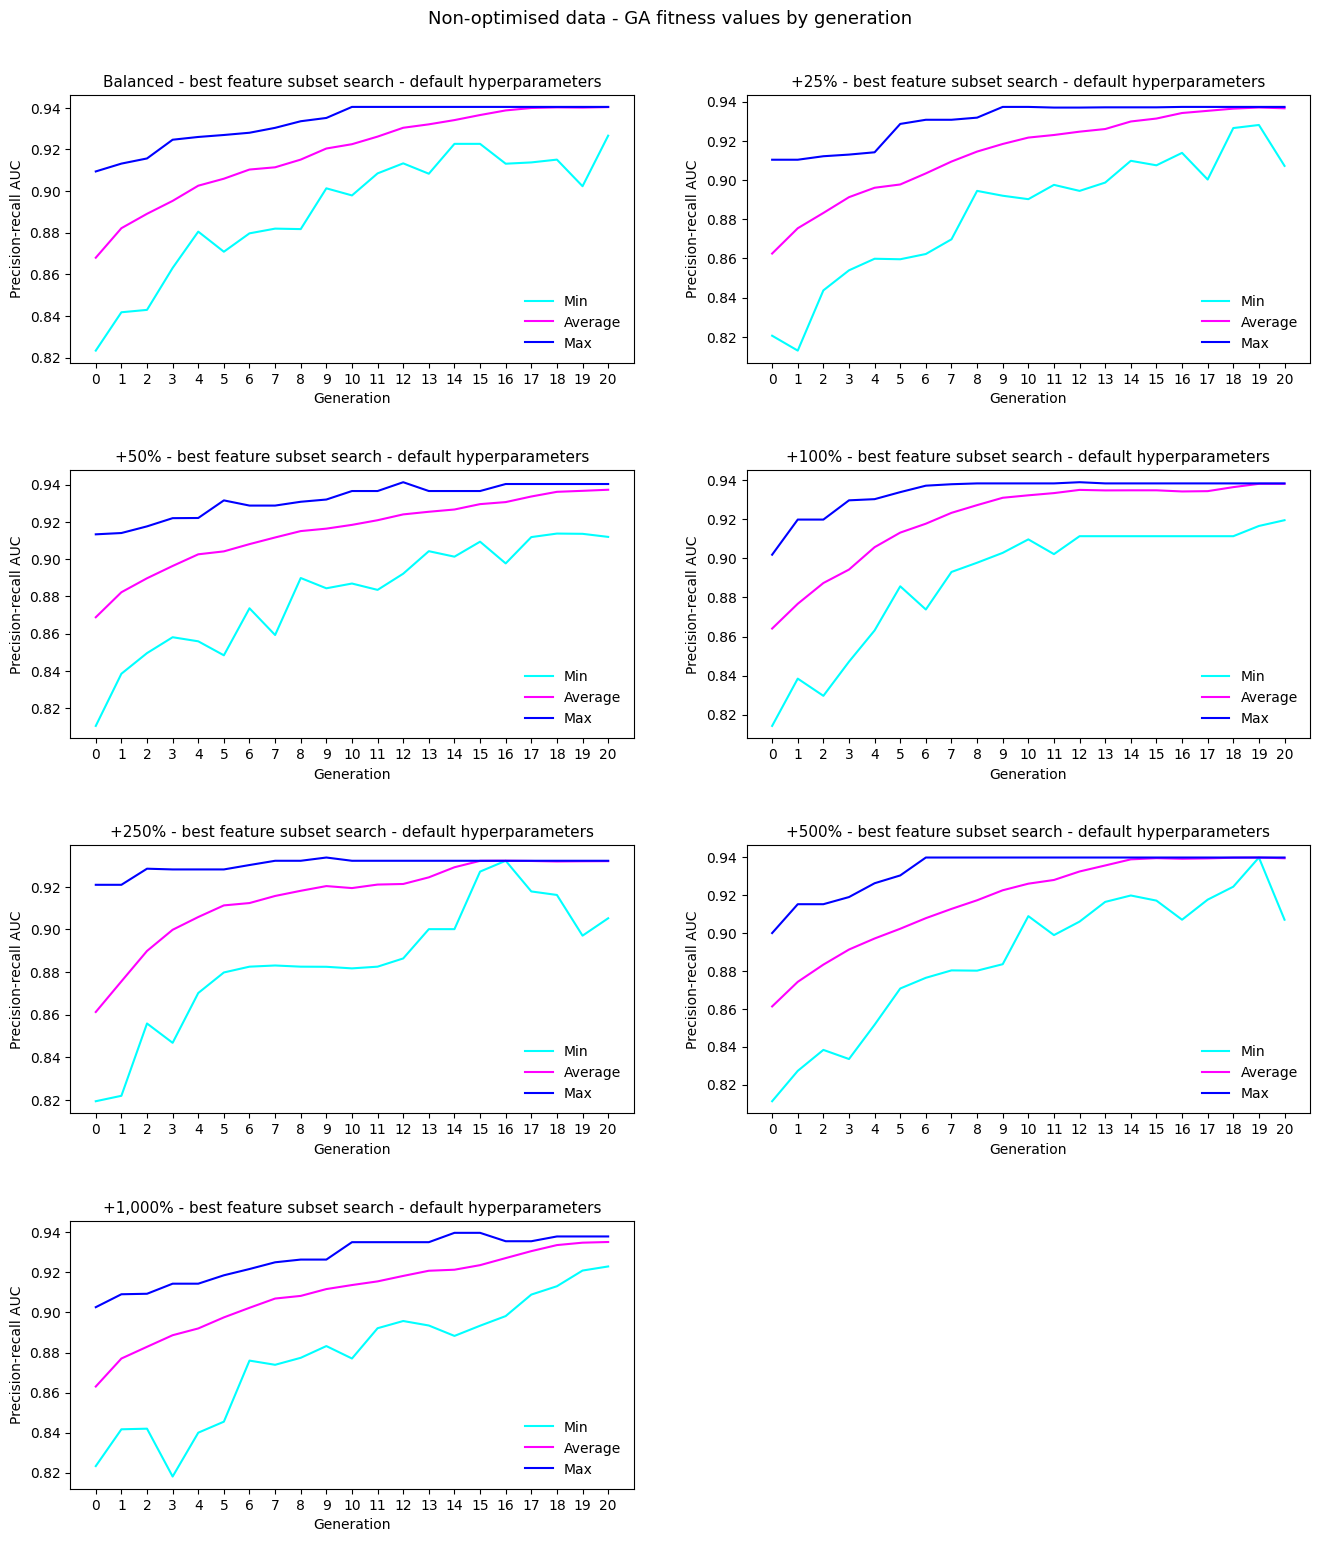

In [ ]:
fig, axes=plt.subplots(4,2,figsize=(16,17),gridspec_kw={'hspace': 0.4}) # width by height

axes[3, 1].set_visible(False)

fit_gen_plot(log_f_bal,   20, 'Balanced - best feature subset search - default hyperparameters', 'Balanced',    fit_score_f_bal,  feats_f_bal,  0, 0)
fit_gen_plot(log_f_25,    20, '+25% - best feature subset search - default hyperparameters',     '+25%',        fit_score_f_25,   feats_f_25,   0, 1)
fit_gen_plot(log_f_50,    20, '+50% - best feature subset search - default hyperparameters',     '+50%',        fit_score_f_50,   feats_f_50,   1, 0)
fit_gen_plot(log_f_100,   20, '+100% - best feature subset search - default hyperparameters',    '+100%',       fit_score_f_100,  feats_f_100,  1, 1)
fit_gen_plot(log_f_250,   20, '+250% - best feature subset search - default hyperparameters',    '+250%',       fit_score_f_250,  feats_f_250,  2, 0)
fit_gen_plot(log_f_500,   20, '+500% - best feature subset search - default hyperparameters',    '+500%',       fit_score_f_500,  feats_f_500,  2, 1)
fit_gen_plot(log_f_1000,  20, '+1,000% - best feature subset search - default hyperparameters',  '+1,000%',     fit_score_f_1000, feats_f_1000, 3, 0)

fig.suptitle('Non-optimised data - GA fitness values by generation', fontsize=13)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

#### 9.2. Non-optimised CTGAN data - GA feats & hypers

Balanced - best individual fitness score: 0.9456986428594545
Balanced - best individual: {'num_leaves': 30, 'max_depth': 15, 'learning_rate': 0.10728291634165336, 'n_estimators': 98, 'subsample_for_bin': 1777, 'min_split_gain': 0.009937878068112218, 'min_child_weight': 0.002851822382234478, 'min_child_samples': 25, 'subsample': 0.8826699245206568, 'subsample_freq': 3, 'colsample_bytree': 0.992954016335875, 'reg_alpha': 0.02916986940286989, 'reg_lambda': 0.03454068435789543}

+25% - best individual fitness score: 0.9413352183257243
+25% - best individual: {'num_leaves': 22, 'max_depth': 12, 'learning_rate': 0.09319611119612227, 'n_estimators': 98, 'subsample_for_bin': 3789, 'min_split_gain': 0.01079563002029255, 'min_child_weight': 0.0025917455571689567, 'min_child_samples': 27, 'subsample': 0.9603538935897381, 'subsample_freq': 1, 'colsample_bytree': 0.971122706897864, 'reg_alpha': 0.03890026602310937, 'reg_lambda': 0.02413914616883063}

+50% - best individual fitness score: 0.94637324

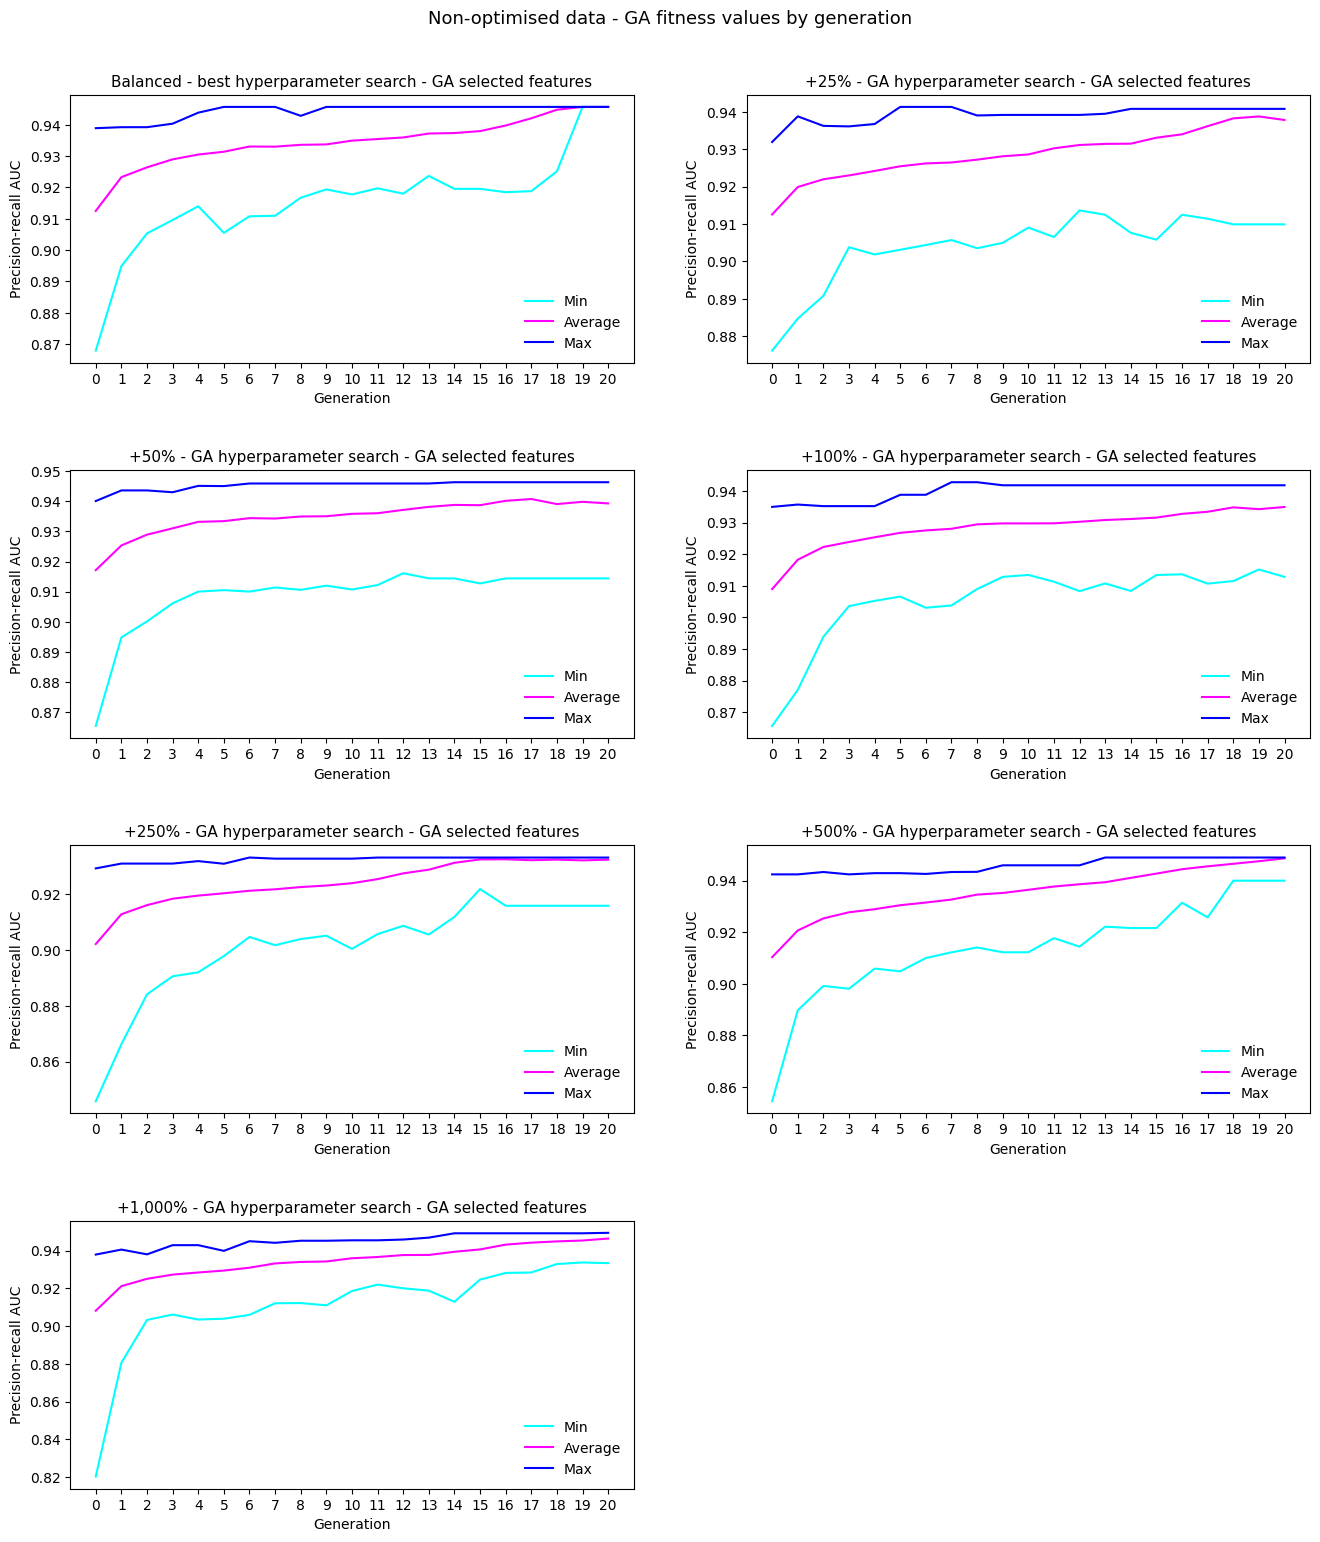

In [ ]:
fig, axes=plt.subplots(4,2,figsize=(16,17),gridspec_kw={'hspace': 0.4}) # width by height

axes[3, 1].set_visible(False)

fit_gen_plot(log_fh_bal,   20, 'Balanced - best hyperparameter search - GA selected features', 'Balanced',    best_fit_score_fh_bal,  best_hyper_fh_bal,  0, 0)
fit_gen_plot(log_fh_25,    20, '+25% - GA hyperparameter search - GA selected features',       '+25%',        best_fit_score_fh_25,   best_hyper_fh_25,   0, 1)
fit_gen_plot(log_fh_50,    20, '+50% - GA hyperparameter search - GA selected features',       '+50%',        best_fit_score_fh_50,   best_hyper_fh_50,   1, 0)
fit_gen_plot(log_fh_100,   20, '+100% - GA hyperparameter search - GA selected features',      '+100%',       best_fit_score_fh_100,  best_hyper_fh_100,  1, 1)
fit_gen_plot(log_fh_250,   20, '+250% - GA hyperparameter search - GA selected features',      '+250%',       best_fit_score_fh_250,  best_hyper_fh_250,  2, 0)
fit_gen_plot(log_fh_500,   20, '+500% - GA hyperparameter search - GA selected features',      '+500%',       best_fit_score_fh_500,  best_hyper_fh_500,  2, 1)
fit_gen_plot(log_fh_1000,  20, '+1,000% - GA hyperparameter search - GA selected features',    '+1,000%',     best_fit_score_fh_1000, best_hyper_fh_1000, 3, 0)

fig.suptitle('Non-optimised data - GA fitness values by generation', fontsize=13)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

#### 9.3. Optimised CTGAN data - GA feats & default hypers

Note that there is no optimised CTGAN data for 'balanced' so its been excluded

+25% - best individual fitness score: 0.9436060876667064
+25% - best individual: ['albumin', 'ast_got', 'calcium', 'direct_bilirubin', 'ph', 'potassium', 'sodium', 'specific_gravity', 'total_cholesterol', 'urine_bilirubin', 'urine_ketone', 'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'diabe1es', 'smoking']

+50% - best individual fitness score: 0.941898058606699
+50% - best individual: ['bun', 'calcium', 'urine_occult_blood', 'ph', 'potassium', 'sodium', 'specific_gravity', 'total_cholesterol', 'uric_acid', 'urine_glucose', 'urine_ketone', 'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'diabe1es', 'smoking']

+100% - best individual fitness score: 0.9452715532499922
+100% - best individual: ['albumin', 'alk', 'bun', 'calcium', 'nitrite', 'sodium', 'specific_gravity', 'total_cholesterol', 'uric_acid', 'urine_ketone', 'age', 'gender', 'smoking', 'drinking', 'bee1lenu1']

+250% - best individual fitness score: 0.9350453494177615
+250% - best individual: ['albumin', 'alk', 'ast_got',

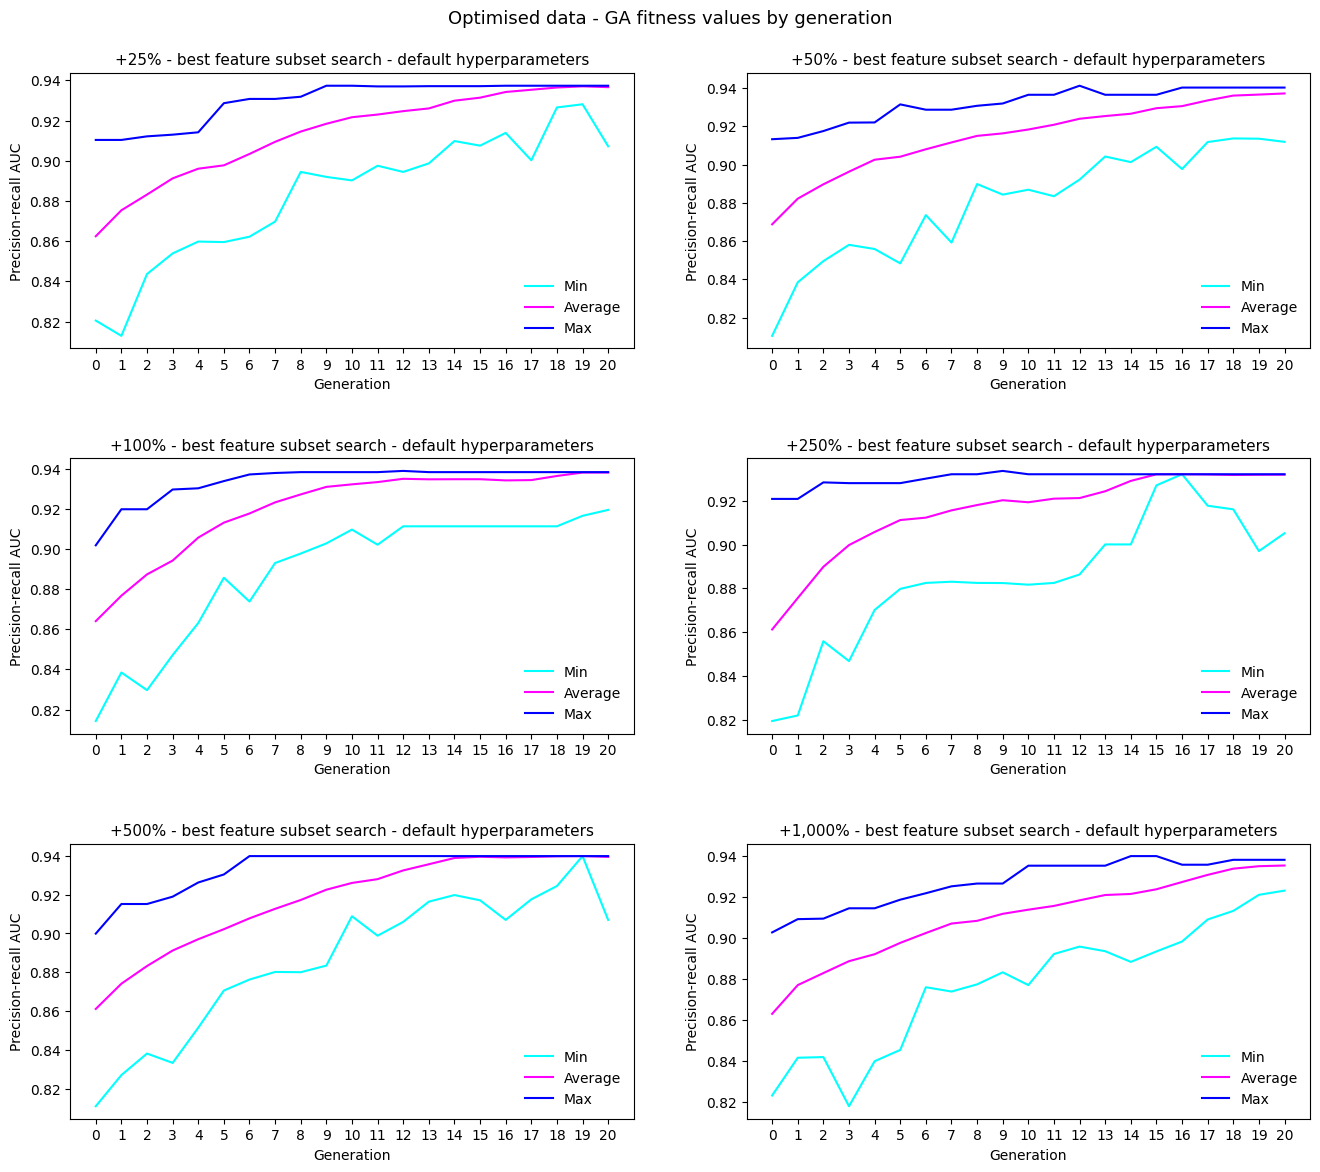

In [ ]:
fig, axes=plt.subplots(3,2,figsize=(16,12.75),gridspec_kw={'hspace': 0.4}) # width by height

#axes[3, 1].set_visible(False)

fit_gen_plot(log_f_25,    20, '+25% - best feature subset search - default hyperparameters',     '+25%',        fit_score_f_25_o,   feats_f_25_o,   0, 0)
fit_gen_plot(log_f_50,    20, '+50% - best feature subset search - default hyperparameters',     '+50%',        fit_score_f_50_o,   feats_f_50_o,   0, 1)
fit_gen_plot(log_f_100,   20, '+100% - best feature subset search - default hyperparameters',    '+100%',       fit_score_f_100_o,  feats_f_100_o,  1, 0)
fit_gen_plot(log_f_250,   20, '+250% - best feature subset search - default hyperparameters',    '+250%',       fit_score_f_250_o,  feats_f_250_o,  1, 1)
fit_gen_plot(log_f_500,   20, '+500% - best feature subset search - default hyperparameters',    '+500%',       fit_score_f_500_o,  feats_f_500_o,  2, 0)
fit_gen_plot(log_f_1000,  20, '+1,000% - best feature subset search - default hyperparameters',  '+1,000%',     fit_score_f_1000_o, feats_f_1000_o, 2, 1)

fig.suptitle('Optimised data - GA fitness values by generation', fontsize=13)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

#### 9.4. Optimised CTGAN data - GA feats & hypers

Note that there is no optimised CTGAN data for 'balanced' so its been excluded

+25% - best individual fitness score: 0.9453341075576832
+25% - best individual: {'num_leaves': 33, 'max_depth': 5, 'learning_rate': 0.11773924722701844, 'n_estimators': 95, 'subsample_for_bin': 2378, 'min_split_gain': 0.013350682590829305, 'min_child_weight': 0.0033856060208060238, 'min_child_samples': 9, 'subsample': 0.7873527510393454, 'subsample_freq': 0, 'colsample_bytree': 0.9172200770224017, 'reg_alpha': 0.0013875808866667173, 'reg_lambda': 0.04424539844918825}

+50% - best individual fitness score: 0.947915477503964
+50% - best individual: {'num_leaves': 33, 'max_depth': 8, 'learning_rate': 0.10865659691009796, 'n_estimators': 116, 'subsample_for_bin': 3326, 'min_split_gain': 0.007765231135556808, 'min_child_weight': 0.001020931490094922, 'min_child_samples': 12, 'subsample': 0.700427404167841, 'subsample_freq': 0, 'colsample_bytree': 0.9354322900960875, 'reg_alpha': 0.0022101644112379137, 'reg_lambda': 0.03235866888978823}

+100% - best individual fitness score: 0.947610533821

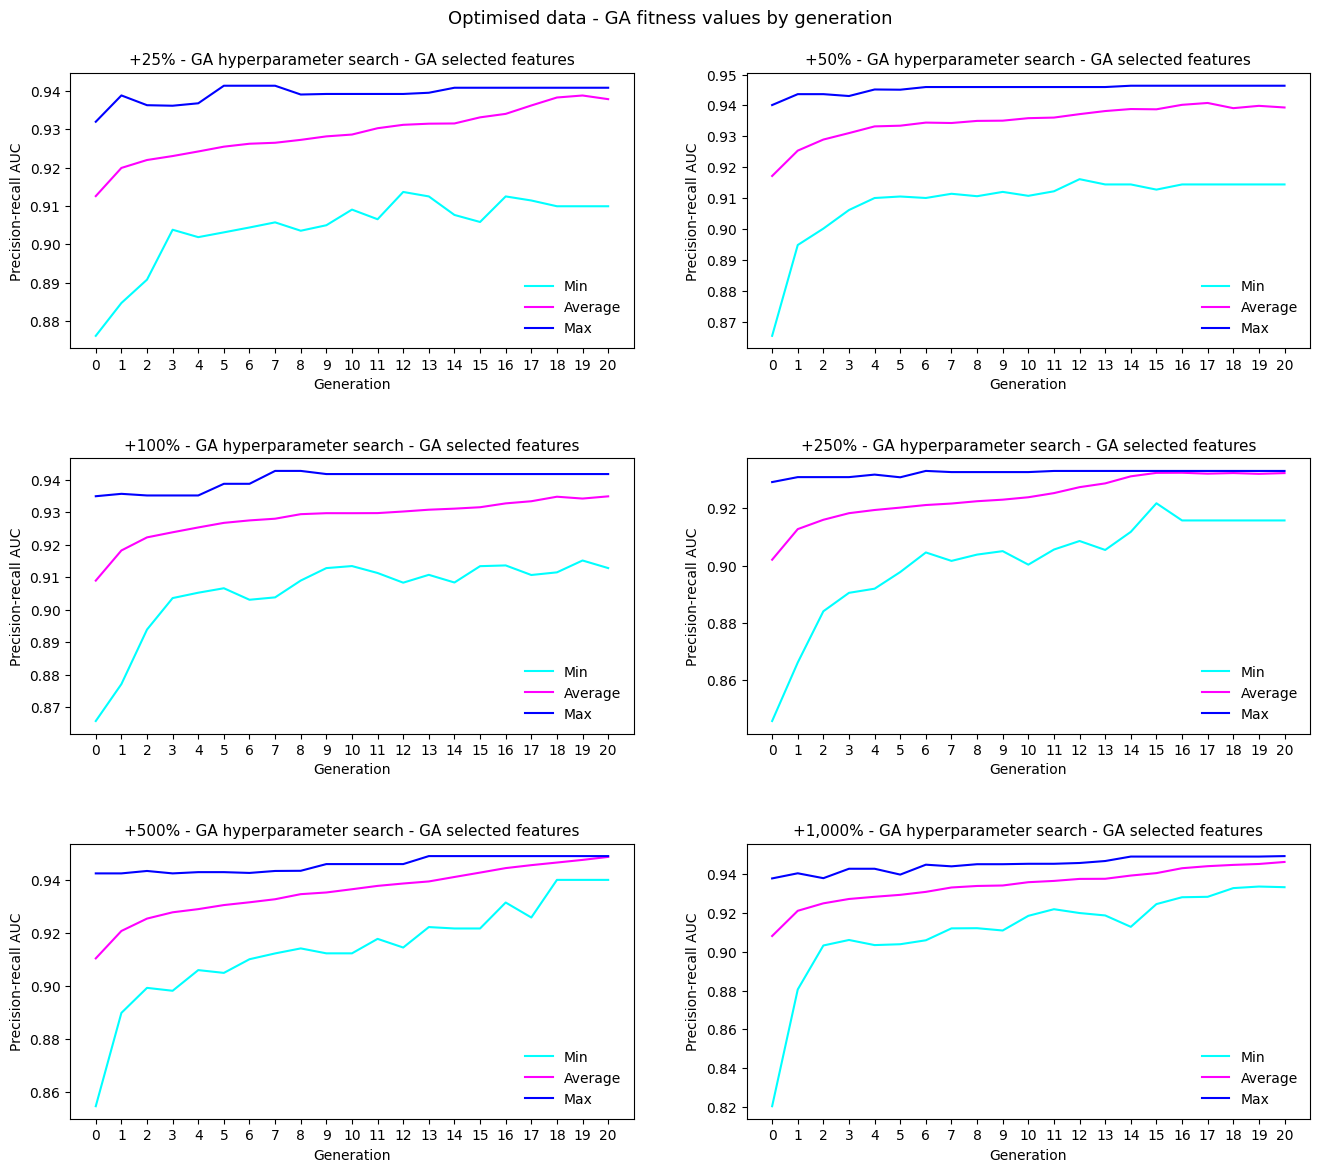

In [ ]:
fig, axes=plt.subplots(3,2,figsize=(16,12.75),gridspec_kw={'hspace': 0.4}) # width by height

#axes[3, 1].set_visible(False)

fit_gen_plot(log_fh_25,    20, '+25% - GA hyperparameter search - GA selected features',       '+25%',        best_fit_score_fh_25_o,   best_hyper_fh_25_o,   0, 0)
fit_gen_plot(log_fh_50,    20, '+50% - GA hyperparameter search - GA selected features',       '+50%',        best_fit_score_fh_50_o,   best_hyper_fh_50_o,   0, 1)
fit_gen_plot(log_fh_100,   20, '+100% - GA hyperparameter search - GA selected features',      '+100%',       best_fit_score_fh_100_o,  best_hyper_fh_100_o,  1, 0)
fit_gen_plot(log_fh_250,   20, '+250% - GA hyperparameter search - GA selected features',      '+250%',       best_fit_score_fh_250_o,  best_hyper_fh_250_o,  1, 1)
fit_gen_plot(log_fh_500,   20, '+500% - GA hyperparameter search - GA selected features',      '+500%',       best_fit_score_fh_500_o,  best_hyper_fh_500_o,  2, 0)
fit_gen_plot(log_fh_1000,  20, '+1,000% - GA hyperparameter search - GA selected features',    '+1,000%',     best_fit_score_fh_1000_o, best_hyper_fh_1000_o, 2, 1)

fig.suptitle('Optimised data - GA fitness values by generation', fontsize=13)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

### **10. Evaluation of models**

#### 10.1. Create metric summary tables

CTGAN non-optimised data

In [ ]:
# GA selection of features - default hyperparameters
metrics_f_all=pd.concat([metrics_f_bal, metrics_f_25, metrics_f_50, metrics_f_100, metrics_f_250, metrics_f_500, metrics_f_1000])
# GA selection of hyperparameters - best feature selections from above
metrics_fh_all=pd.concat([metrics_fh_bal, metrics_fh_25, metrics_fh_50, metrics_fh_100, metrics_fh_250, metrics_fh_500, metrics_fh_1000])

CTGAN optimised data

In [ ]:
# Here added non-optimised 'bal' model results for comparative purposes only

# GA selection of features - default hyperparameters
metrics_f_all_o=pd.concat([metrics_f_bal, metrics_f_25_o, metrics_f_50_o, metrics_f_100_o, metrics_f_250_o, metrics_f_500_o, metrics_f_1000_o])
# GA selection of hyperparameters - best feature selections from above
metrics_fh_all_o=pd.concat([metrics_fh_bal, metrics_fh_25_o, metrics_fh_50_o, metrics_fh_100_o, metrics_fh_250_o, metrics_fh_500_o, metrics_fh_1000_o])

Save tables

In [ ]:
metrics_f_all.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all.pkl')
metrics_fh_all.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all.pkl')
metrics_f_all_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all_o.pkl')
metrics_fh_all_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all_o.pkl')

Review tables

In [ ]:
# Non-optimised CTGAN data - features GA only - default hyperparameters
metrics_f_all

tp  tn  fp  fn   logloss  accuracy    recall  precision  specificity  \
_bal   156  35  12  55  0.469490  0.740310  0.739336   0.928571     0.744681   
_25    146  33  14  65  0.496455  0.693798  0.691943   0.912500     0.702128   
_50    125  40   7  86  0.468632  0.639535  0.592417   0.946970     0.851064   
_100   148  35  12  63  0.504586  0.709302  0.701422   0.925000     0.744681   
_250   146  34  13  65  0.526194  0.697674  0.691943   0.918239     0.723404   
_500   129  40   7  82  0.489489  0.655039  0.611374   0.948529     0.851064   
_1000  125  42   5  86  0.504182  0.647287  0.592417   0.961538     0.893617   

       f1_score    pr_auc   roc_auc  valid_score  
_bal   0.823219  0.940606  0.777755     0.859396  
_25    0.787062  0.937505  0.762832     0.925880  
_50    0.728863  0.941474  0.775033     0.943918  
_100   0.797844  0.939137  0.765655     0.972379  
_250   0.789189  0.933920  0.741051     0.982332  
_500   0.743516  0.939954  0.758193     0.995775  
_1000  0.733138  0.939957  0.756983     0.999059

In [ ]:
# Non-optimised CTGAN data - features & hyperparameters GA
metrics_fh_all

tp  tn  fp  fn   logloss  accuracy    recall  precision  specificity  \
_bal   135  41   6  76  0.434393  0.682171  0.639810   0.957447     0.872340   
_25    164  31  16  47  0.451846  0.755814  0.777251   0.911111     0.659574   
_50    128  43   4  83  0.432465  0.662791  0.606635   0.969697     0.914894   
_100   151  36  11  60  0.526202  0.724806  0.715640   0.932099     0.765957   
_250   122  38   9  89  0.478335  0.620155  0.578199   0.931298     0.808511   
_500   154  34  13  57  0.416574  0.728682  0.729858   0.922156     0.723404   
_1000  139  37  10  72  0.399424  0.682171  0.658768   0.932886     0.787234   

       f1_score    pr_auc   roc_auc  valid_score  
_bal   0.767045  0.945899  0.793183     0.872660  
_25    0.838875  0.941509  0.769890     0.931495  
_50    0.746356  0.946525  0.782192     0.945796  
_100   0.809651  0.942979  0.780982     0.973261  
_250   0.713450  0.933294  0.739437     0.982942  
_500   0.814815  0.949069  0.790662     0.995865  
_1000  0.772222  0.949608  0.791469     0.999131

In [ ]:
# Optimised CTGAN data - features GA only - default hyperparameters
metrics_f_all_o

tp  tn  fp  fn   logloss  accuracy    recall  precision  \
_bal     156  35  12  55  0.469490  0.740310  0.739336   0.928571   
_25_o    143  37  10  68  0.471154  0.697674  0.677725   0.934641   
_50_o    148  35  12  63  0.495465  0.709302  0.701422   0.925000   
_100_o   159  33  14  52  0.480700  0.744186  0.753555   0.919075   
_250_o   144  34  13  67  0.552227  0.689922  0.682464   0.917197   
_500_o   153  32  15  58  0.511203  0.717054  0.725118   0.910714   
_1000_o  149  32  15  62  0.540613  0.701550  0.706161   0.908537   

         specificity  f1_score    pr_auc   roc_auc  valid_score  
_bal        0.744681  0.823219  0.940606  0.777755     0.859396  
_25_o       0.787234  0.785714  0.943780  0.782192     0.890566  
_50_o       0.744681  0.797844  0.942062  0.764647     0.939961  
_100_o      0.702128  0.828125  0.945432  0.784814     0.965836  
_250_o      0.723404  0.782609  0.935251  0.754966     0.981528  
_500_o      0.680851  0.807388  0.935096  0.757185     0.993948  
_1000_o     0.680851  0.794667  0.937627  0.755269     0.996230

In [ ]:
# Optimised CTGAN data - features & hyperparameters GA
metrics_fh_all_o

tp  tn  fp  fn   logloss  accuracy    recall  precision  \
_bal     135  41   6  76  0.434393  0.682171  0.639810   0.957447   
_25_o    169  33  14  42  0.410488  0.782946  0.800948   0.923497   
_50_o    143  39   8  68  0.508325  0.705426  0.677725   0.947020   
_100_o   120  43   4  91  0.420769  0.631783  0.568720   0.967742   
_250_o   155  34  13  56  0.495472  0.732558  0.734597   0.922619   
_500_o   169  29  18  42  0.406961  0.767442  0.800948   0.903743   
_1000_o  135  39   8  76  0.502462  0.674419  0.639810   0.944056   

         specificity  f1_score    pr_auc   roc_auc  valid_score  
_bal        0.872340  0.767045  0.945899  0.793183     0.872660  
_25_o       0.702128  0.857868  0.945507  0.792074     0.887306  
_50_o       0.829787  0.790055  0.948054  0.780478     0.935298  
_100_o      0.914894  0.716418  0.947756  0.786427     0.965157  
_250_o      0.723404  0.817942  0.942185  0.778159     0.979181  
_500_o      0.617021  0.849246  0.939075  0.774024     0.994299  
_1000_o     0.829787  0.762712  0.940896  0.771100     0.996448

#### 10.2. Create PR-AUC & ROC-AUC plots

##### 10.2.1. Non-optimised CTGAN data - GA feats & default hypers vs GA feats & hypers

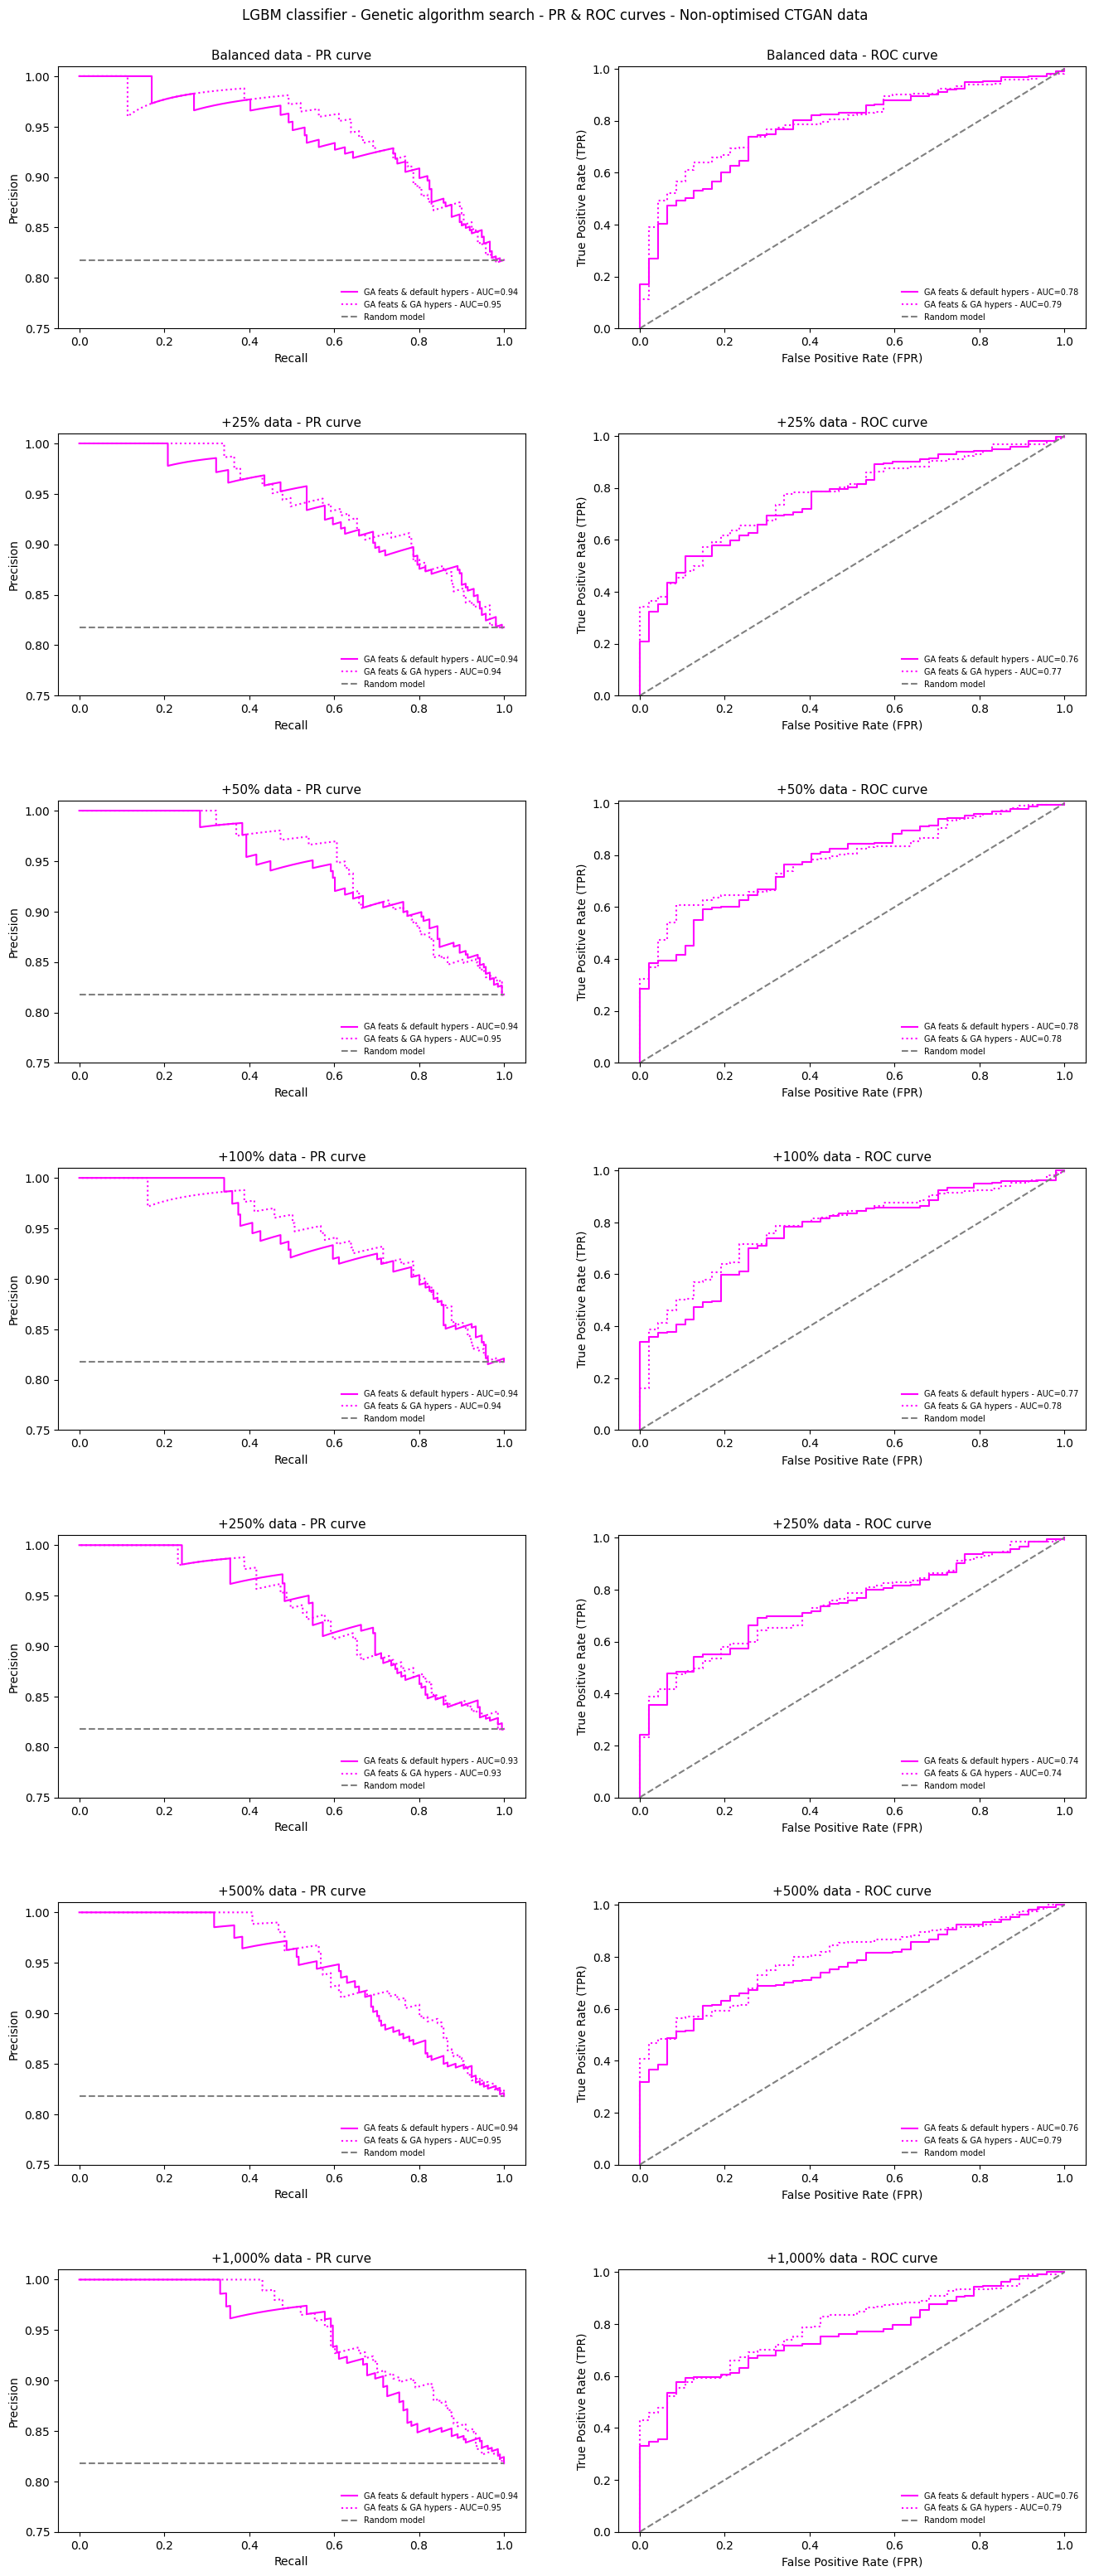

In [ ]:
fig, axes=plt.subplots(7,2,figsize=(16,35),gridspec_kw={'hspace': 0.4}) # width by height

##### bal #####
auc_curves2(# PR curve
            pr_curve_dic_f_bal['_bal'],   pr_curve_dic_fh_bal['_bal'],
            # ROC curve
            roc_curve_dic_f_bal['_bal'],  roc_curve_dic_fh_bal['_bal'],
            # Title
            'Balanced data',
            # Subplot positions - row=i, col0=j, col1=k
            0,0,1)

##### +25% #####
auc_curves2(# PR curve
            pr_curve_dic_f_25['_25'],   pr_curve_dic_fh_25['_25'],
            # ROC curve
            roc_curve_dic_f_25['_25'],  roc_curve_dic_fh_25['_25'],
            # Title
            '+25% data',
            # Subplot positions - row=i, col0=j, col1=k
            1,0,1)

##### +50% #####
auc_curves2(# PR curve
            pr_curve_dic_f_50['_50'],   pr_curve_dic_fh_50['_50'],
            # ROC curve
            roc_curve_dic_f_50['_50'],  roc_curve_dic_fh_50['_50'],
            # Title
            '+50% data',
            # Subplot positions - row=i, col0=j, col1=k
            2,0,1)

##### +100% #####
auc_curves2(# PR curve
            pr_curve_dic_f_100['_100'],   pr_curve_dic_fh_100['_100'],
            # ROC curve
            roc_curve_dic_f_100['_100'],  roc_curve_dic_fh_100['_100'],
            # Title
            '+100% data',
            # Subplot positions - row=i, col0=j, col1=k
            3,0,1)

##### +250% #####
auc_curves2(# PR curve
            pr_curve_dic_f_250['_250'],   pr_curve_dic_fh_250['_250'],
            # ROC curve
            roc_curve_dic_f_250['_250'],  roc_curve_dic_fh_250['_250'],
            # Title
            '+250% data',
            # Subplot positions - row=i, col0=j, col1=k
            4,0,1)

# ##### +500% #####
auc_curves2(# PR curve
            pr_curve_dic_f_500['_500'],   pr_curve_dic_fh_500['_500'],
            # ROC curve
            roc_curve_dic_f_500['_500'],  roc_curve_dic_fh_500['_500'],
            # Title
            '+500% data',
            # Subplot positions - row=i, col0=j, col1=k
            5,0,1)

##### +1000% #####
auc_curves2(# PR curve
            pr_curve_dic_f_1000['_1000'],   pr_curve_dic_fh_1000['_1000'],
            # ROC curve
            roc_curve_dic_f_1000['_1000'],  roc_curve_dic_fh_1000['_1000'],
            # Title
            '+1,000% data',
            # Subplot positions - row=i, col0=j, col1=k
            6,0,1)

fig.suptitle('LGBM classifier - Genetic algorithm search - PR & ROC curves - Non-optimised CTGAN data', fontsize=12)
fig.subplots_adjust(top=0.96)

plt.tight_layout()
plt.show()

##### 10.2.2. Optimised CTGAN data - GA feats & default hypers vs GA feats & hypers
Note that there is no optimised CTGAN data for 'balanced' so its been excluded

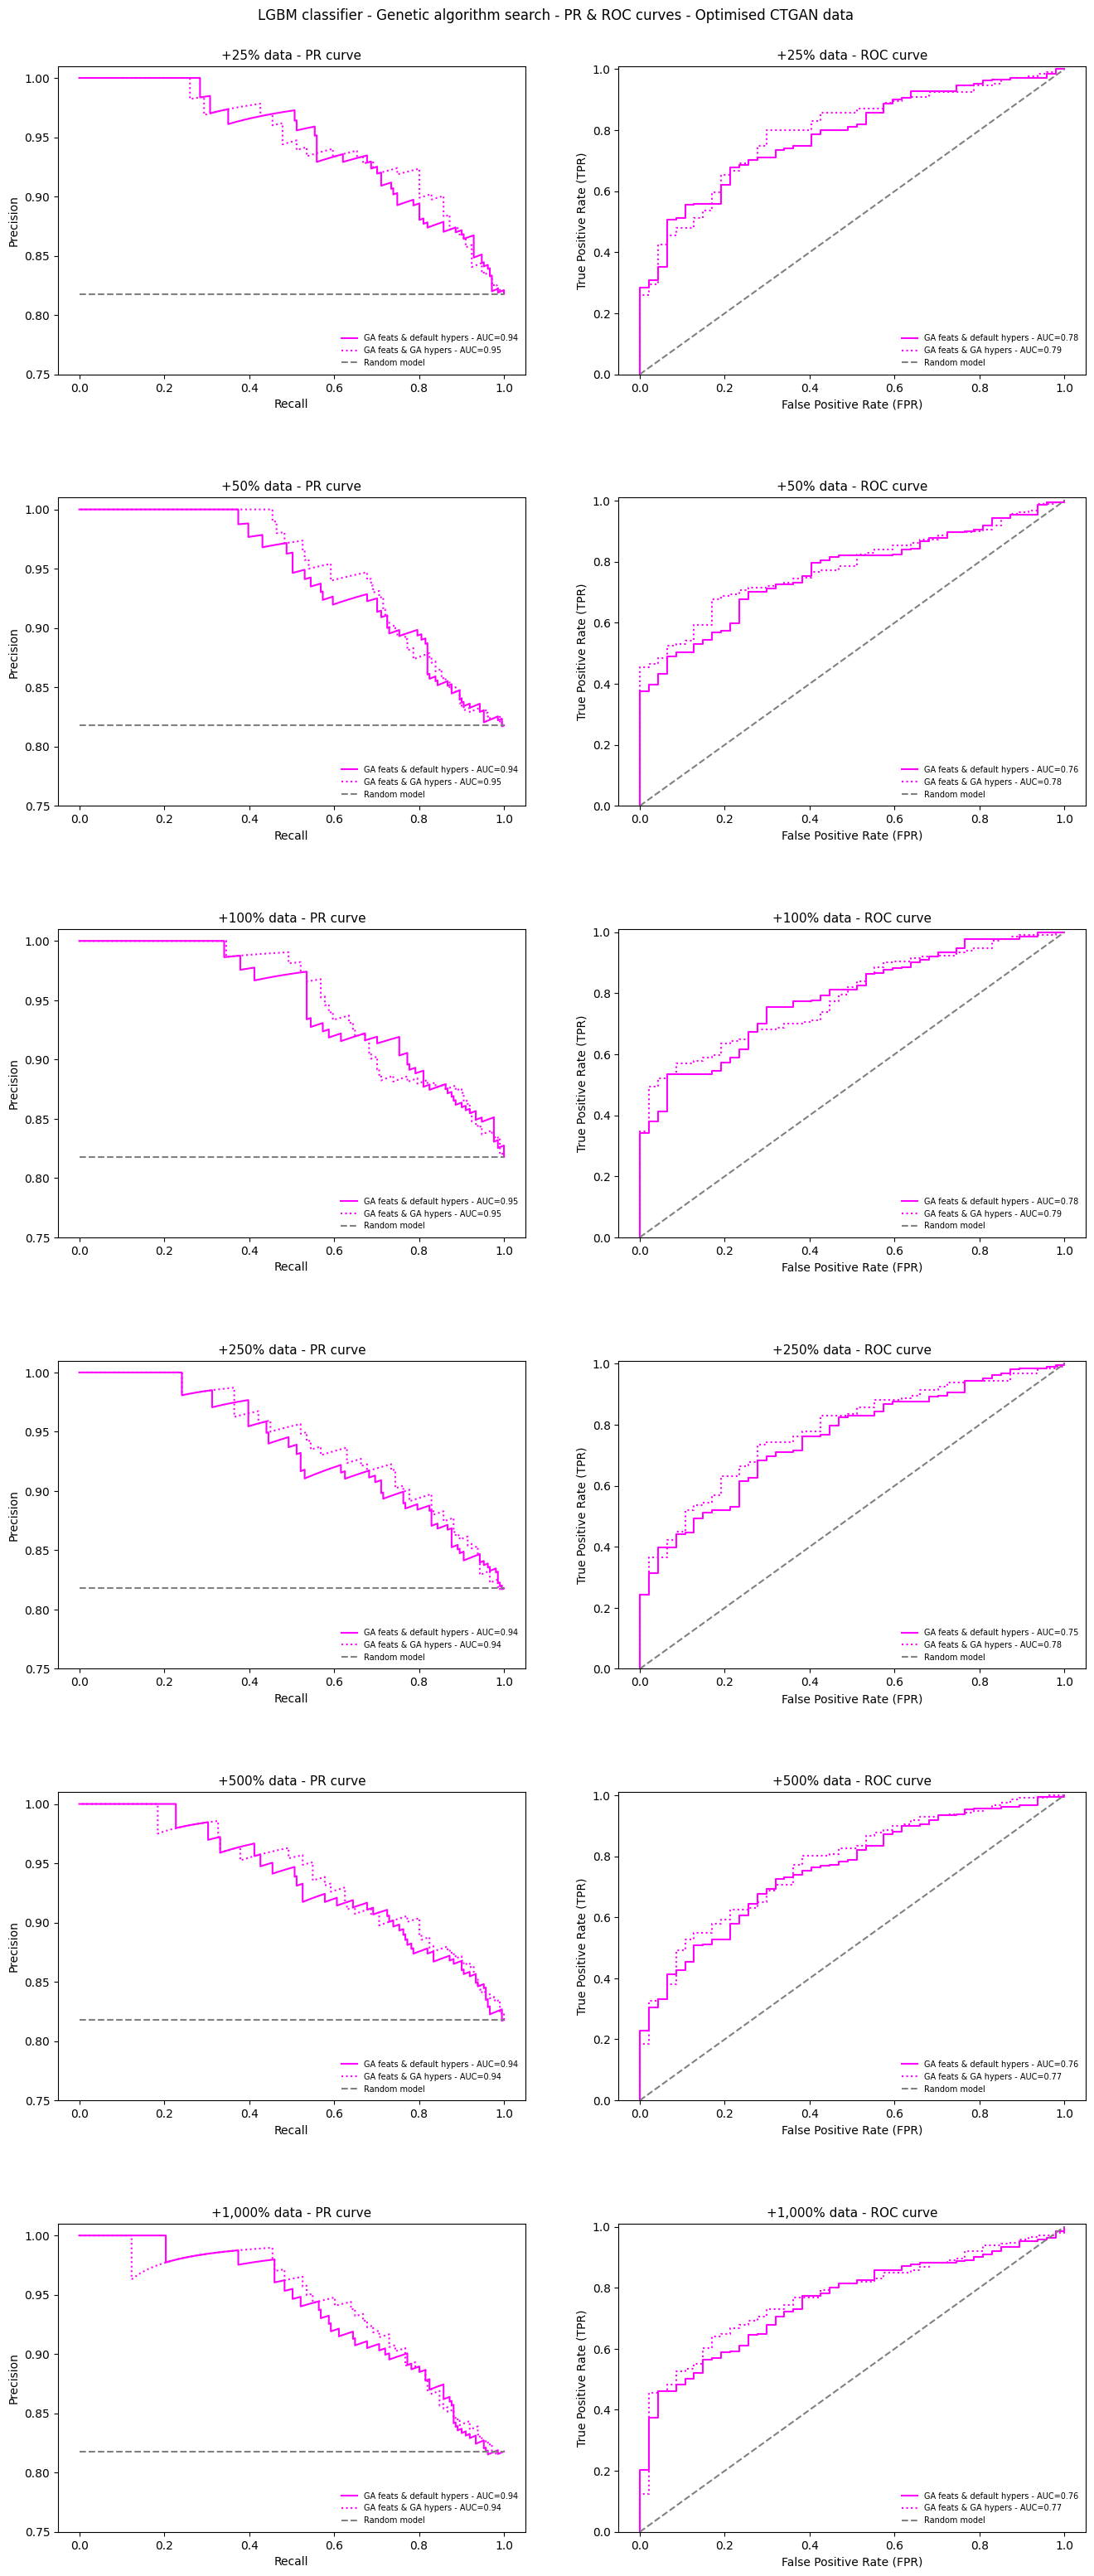

In [ ]:
fig, axes=plt.subplots(6,2,figsize=(16,35),gridspec_kw={'hspace': 0.4}) # width by height

##### +25% #####
auc_curves2(# PR curve
            pr_curve_dic_f_25_o['_25_o'],   pr_curve_dic_fh_25_o['_25_o'],
            # ROC curve
            roc_curve_dic_f_25_o['_25_o'],  roc_curve_dic_fh_25_o['_25_o'],
            # Title
            '+25% data',
            # Subplot positions - row=i, col0=j, col1=k
            0,0,1)

##### +50% #####
auc_curves2(# PR curve
            pr_curve_dic_f_50_o['_50_o'],   pr_curve_dic_fh_50_o['_50_o'],
            # ROC curve
            roc_curve_dic_f_50_o['_50_o'],  roc_curve_dic_fh_50_o['_50_o'],
            # Title
            '+50% data',
            # Subplot positions - row=i, col0=j, col1=k
            1,0,1)

##### +100% #####
auc_curves2(# PR curve
            pr_curve_dic_f_100_o['_100_o'],   pr_curve_dic_fh_100_o['_100_o'],
            # ROC curve
            roc_curve_dic_f_100_o['_100_o'],  roc_curve_dic_fh_100_o['_100_o'],
            # Title
            '+100% data',
            # Subplot positions - row=i, col0=j, col1=k
            2,0,1)

##### +250% #####
auc_curves2(# PR curve
            pr_curve_dic_f_250_o['_250_o'],   pr_curve_dic_fh_250_o['_250_o'],
            # ROC curve
            roc_curve_dic_f_250_o['_250_o'],  roc_curve_dic_fh_250_o['_250_o'],
            # Title
            '+250% data',
            # Subplot positions - row=i, col0=j, col1=k
            3,0,1)

# ##### +500% #####
auc_curves2(# PR curve
            pr_curve_dic_f_500_o['_500_o'],   pr_curve_dic_fh_500_o['_500_o'],
            # ROC curve
            roc_curve_dic_f_500_o['_500_o'],  roc_curve_dic_fh_500_o['_500_o'],
            # Title
            '+500% data',
            # Subplot positions - row=i, col0=j, col1=k
            4,0,1)

##### +1000% #####
auc_curves2(# PR curve
            pr_curve_dic_f_1000_o['_1000_o'],   pr_curve_dic_fh_1000_o['_1000_o'],
            # ROC curve
            roc_curve_dic_f_1000_o['_1000_o'],  roc_curve_dic_fh_1000_o['_1000_o'],
            # Title
            '+1,000% data',
            # Subplot positions - row=i, col0=j, col1=k
            5,0,1)

fig.suptitle('LGBM classifier - Genetic algorithm search - PR & ROC curves - Optimised CTGAN data', fontsize=12)
fig.subplots_adjust(top=0.96)

plt.tight_layout()
plt.show()

##### 10.2.3. Non-optimised CTGAN data - GA feats & hypers vs optimised CTGAN data - GA feats & hypers
Note that there is no optimised CTGAN data for 'balanced' so its been excluded

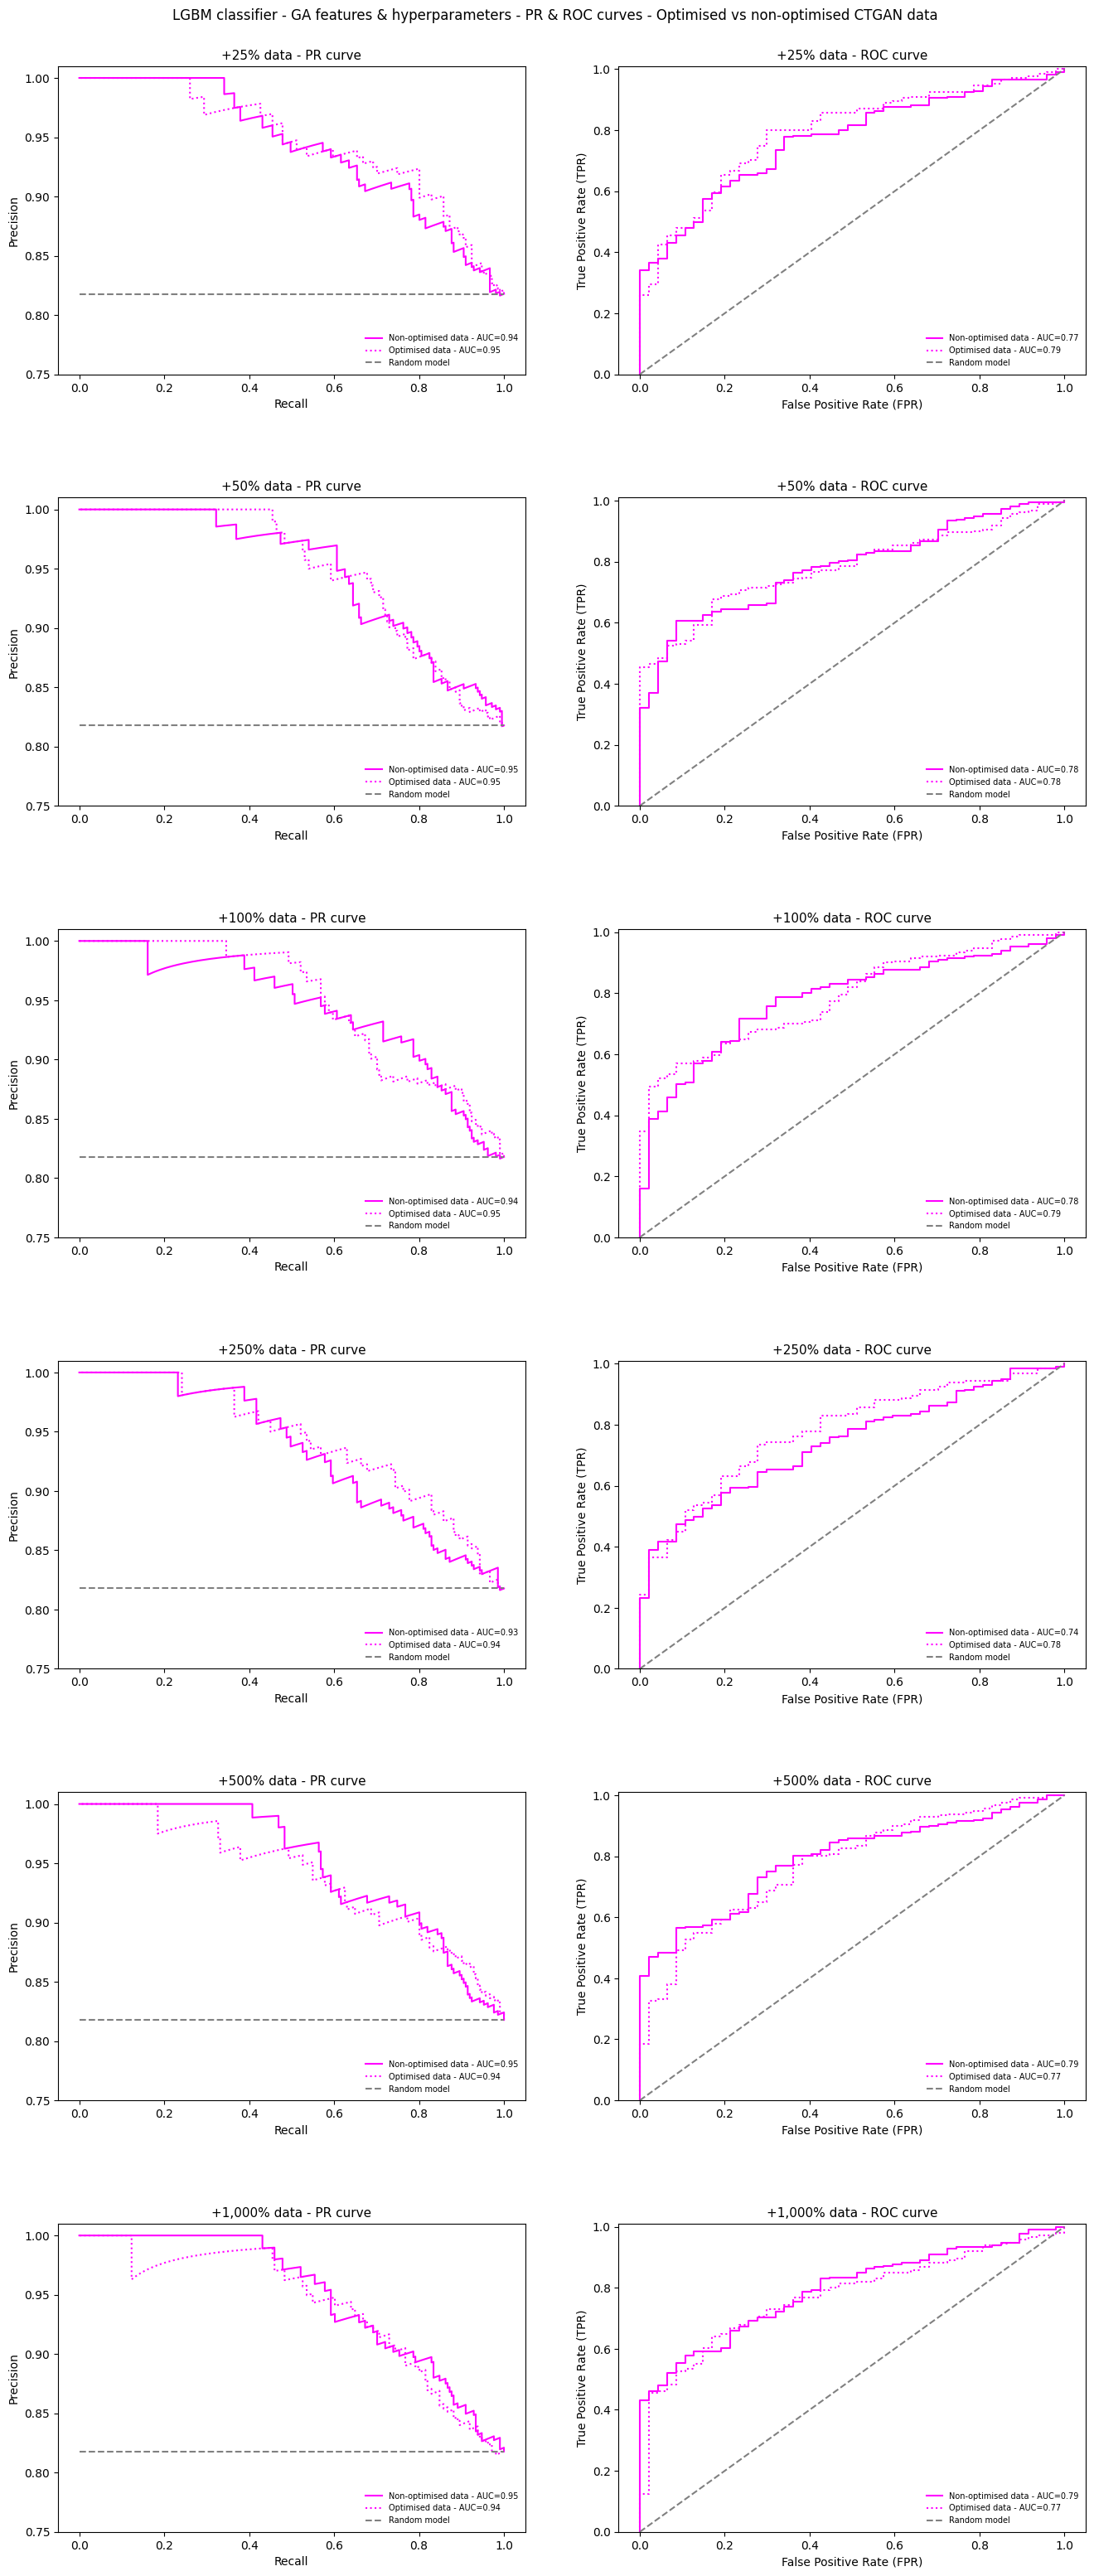

In [ ]:
fig, axes=plt.subplots(6,2,figsize=(16,35),gridspec_kw={'hspace': 0.4}) # width by height

##### +25% #####
auc_curves3(# PR curve
            pr_curve_dic_fh_25['_25'],   pr_curve_dic_fh_25_o['_25_o'],
            # ROC curve
            roc_curve_dic_fh_25['_25'],  roc_curve_dic_fh_25_o['_25_o'],
            # Title
            '+25% data',
            # Subplot positions - row=i, col0=j, col1=k
            0,0,1)

##### +50% #####
auc_curves3(# PR curve
            pr_curve_dic_fh_50['_50'],   pr_curve_dic_fh_50_o['_50_o'],
            # ROC curve
            roc_curve_dic_fh_50['_50'],  roc_curve_dic_fh_50_o['_50_o'],
            # Title
            '+50% data',
            # Subplot positions - row=i, col0=j, col1=k
            1,0,1)

##### +100% #####
auc_curves3(# PR curve
            pr_curve_dic_fh_100['_100'],   pr_curve_dic_fh_100_o['_100_o'],
            # ROC curve
            roc_curve_dic_fh_100['_100'],  roc_curve_dic_fh_100_o['_100_o'],
            # Title
            '+100% data',
            # Subplot positions - row=i, col0=j, col1=k
            2,0,1)

##### +250% #####
auc_curves3(# PR curve
            pr_curve_dic_fh_250['_250'],   pr_curve_dic_fh_250_o['_250_o'],
            # ROC curve
            roc_curve_dic_fh_250['_250'],  roc_curve_dic_fh_250_o['_250_o'],
            # Title
            '+250% data',
            # Subplot positions - row=i, col0=j, col1=k
            3,0,1)

# ##### +500% #####
auc_curves3(# PR curve
            pr_curve_dic_fh_500['_500'],   pr_curve_dic_fh_500_o['_500_o'],
            # ROC curve
            roc_curve_dic_fh_500['_500'],  roc_curve_dic_fh_500_o['_500_o'],
            # Title
            '+500% data',
            # Subplot positions - row=i, col0=j, col1=k
            4,0,1)

##### +1000% #####
auc_curves3(# PR curve
            pr_curve_dic_fh_1000['_1000'],   pr_curve_dic_fh_1000_o['_1000_o'],
            # ROC curve
            roc_curve_dic_fh_1000['_1000'],  roc_curve_dic_fh_1000_o['_1000_o'],
            # Title
            '+1,000% data',
            # Subplot positions - row=i, col0=j, col1=k
            5,0,1)

fig.suptitle('LGBM classifier - GA features & hyperparameters - PR & ROC curves - Optimised vs non-optimised CTGAN data', fontsize=12)
fig.subplots_adjust(top=0.96)

plt.tight_layout()
plt.show()

#### 10.3. Feature rank plots

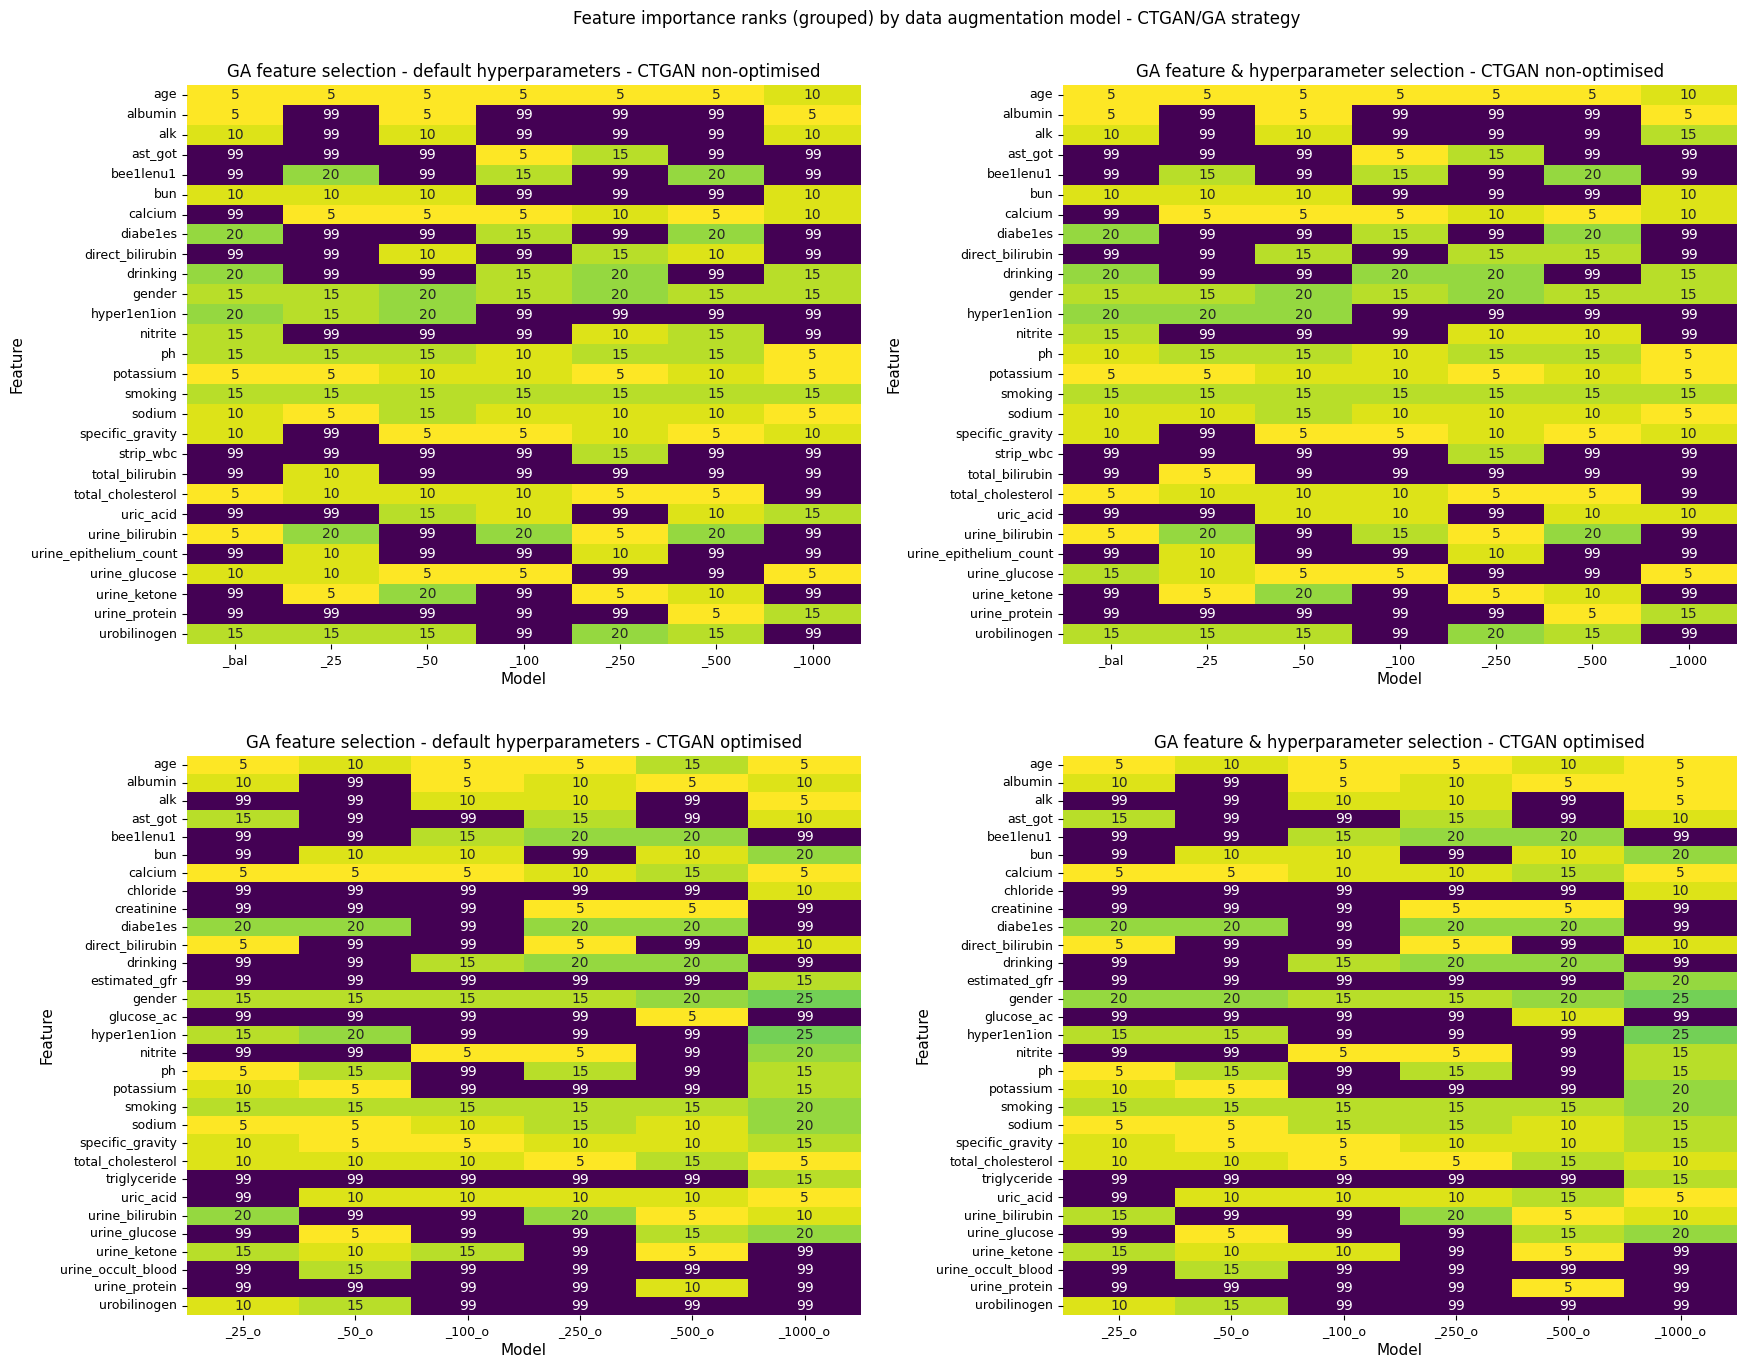

In [ ]:
########### Pull together the ranks for each augmentation scenario into one dataframe by GA/CTGAN strategy ##########

##### Non-optimised CTGAN data #####

# GA feats & default hypers
non_opt_f=feat_imp_f_bal
for i in [feat_imp_f_25, feat_imp_f_50, feat_imp_f_100,feat_imp_f_250, feat_imp_f_500, feat_imp_f_1000]:
  non_opt_f=pd.merge(non_opt_f, i, on='feature', how='outer')

# GA feats & hypers
non_opt_fh=feat_imp_fh_bal
for i in [feat_imp_fh_25, feat_imp_fh_50, feat_imp_fh_100,feat_imp_fh_250, feat_imp_fh_500, feat_imp_fh_1000]:
  non_opt_fh=pd.merge(non_opt_fh, i, on='feature', how='outer')

##### Optimised CTGAN data #####

# GA feats & default hypers
opt_f=feat_imp_f_25_o
for i in [feat_imp_f_50_o, feat_imp_f_100_o, feat_imp_f_250_o, feat_imp_f_500_o, feat_imp_f_1000_o]:
  opt_f=pd.merge(opt_f, i, on='feature', how='outer')

# GA feats & hypers
opt_fh=feat_imp_fh_25_o
for i in [feat_imp_fh_50_o, feat_imp_fh_100_o, feat_imp_fh_250_o, feat_imp_fh_500_o, feat_imp_fh_1000_o]:
  opt_fh=pd.merge(opt_fh, i, on='feature', how='outer')

########### Plot heatmaps ##########

fig,axes=plt.subplots(2,2,figsize=(20,15),gridspec_kw={'hspace': 0.2, 'wspace': 0.3}) # width by height

feat_heatmap(non_opt_f,  'GA feature selection - default hyperparameters - CTGAN non-optimised',    0, 0,)
feat_heatmap(non_opt_fh, 'GA feature & hyperparameter selection - CTGAN non-optimised',             0, 1,)
feat_heatmap(opt_f,      'GA feature selection - default hyperparameters - CTGAN optimised',        1, 0, 1)
feat_heatmap(opt_fh,     'GA feature & hyperparameter selection - CTGAN optimised',                 1, 1, 1)

fig.suptitle('Feature importance ranks (grouped) by data augmentation model - CTGAN/GA strategy', fontsize=12)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

### 11. Load all relevant files from model runs

In [ ]:
########## CTGAN non-optimised data #########

# _bal

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_bal', 'rb') as file:
    log_f_bal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_bal', 'rb') as file:
    feats_f_bal=pickle.load(file)
metrics_f_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_bal.pkl')
feat_imp_f_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_bal.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_bal', 'rb') as file:
    pr_curve_dic_f_bal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_bal', 'rb') as file:
    roc_curve_dic_f_bal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_bal', 'rb') as file:
    fit_score_f_bal=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_bal', 'rb') as file:
    log_fh_bal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_bal', 'rb') as file:
    best_hyper_fh_bal=pickle.load(file)
metrics_fh_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_bal.pkl')
feat_imp_fh_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_bal.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_bal', 'rb') as file:
    pr_curve_dic_fh_bal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_bal', 'rb') as file:
    roc_curve_dic_fh_bal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_bal', 'rb') as file:
    best_fit_score_fh_bal=pickle.load(file)

# _25

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_25', 'rb') as file:
    log_f_25=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_25', 'rb') as file:
    feats_f_25=pickle.load(file)
metrics_f_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_25.pkl')
feat_imp_f_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_25.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_25', 'rb') as file:
    pr_curve_dic_f_25=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_25', 'rb') as file:
    roc_curve_dic_f_25=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_25', 'rb') as file:
    fit_score_f_25=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_25', 'rb') as file:
    log_fh_25=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_25', 'rb') as file:
    best_hyper_fh_25=pickle.load(file)
metrics_fh_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25.pkl')
feat_imp_fh_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_25.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25', 'rb') as file:
    pr_curve_dic_fh_25=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25', 'rb') as file:
    roc_curve_dic_fh_25=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_25', 'rb') as file:
    best_fit_score_fh_25=pickle.load(file)

# _50

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_50', 'rb') as file:
    log_f_50=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50', 'rb') as file:
    feats_f_50=pickle.load(file)
metrics_f_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_50.pkl')
feat_imp_f_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_50.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_50', 'rb') as file:
    pr_curve_dic_f_50=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_50', 'rb') as file:
    roc_curve_dic_f_50=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_50', 'rb') as file:
    fit_score_f_50=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_50', 'rb') as file:
    log_fh_50=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50', 'rb') as file:
    best_hyper_fh_50=pickle.load(file)
metrics_fh_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50.pkl')
feat_imp_fh_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50', 'rb') as file:
    pr_curve_dic_fh_50=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50', 'rb') as file:
    roc_curve_dic_fh_50=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_50', 'rb') as file:
    best_fit_score_fh_50=pickle.load(file)

# _100

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_100', 'rb') as file:
    log_f_100=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_100', 'rb') as file:
    feats_f_100=pickle.load(file)
metrics_f_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_100.pkl')
feat_imp_f_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_100.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_100', 'rb') as file:
    pr_curve_dic_f_100=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_100', 'rb') as file:
    roc_curve_dic_f_100=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_100', 'rb') as file:
    fit_score_f_100=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_100', 'rb') as file:
    log_fh_100=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_100', 'rb') as file:
    best_hyper_fh_100=pickle.load(file)
metrics_fh_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_100.pkl')
feat_imp_fh_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_100.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_100', 'rb') as file:
    pr_curve_dic_fh_100=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_100', 'rb') as file:
    roc_curve_dic_fh_100=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_100', 'rb') as file:
    best_fit_score_fh_100=pickle.load(file)

# _250

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_250', 'rb') as file:
    log_f_250=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_250', 'rb') as file:
    feats_f_250=pickle.load(file)
metrics_f_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_250.pkl')
feat_imp_f_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_250.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_250', 'rb') as file:
    pr_curve_dic_f_250=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_250', 'rb') as file:
    roc_curve_dic_f_250=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_250', 'rb') as file:
    fit_score_f_250=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_250', 'rb') as file:
    log_fh_250=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_250', 'rb') as file:
    best_hyper_fh_250=pickle.load(file)
metrics_fh_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250.pkl')
feat_imp_fh_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_250.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_250', 'rb') as file:
    pr_curve_dic_fh_250=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_250', 'rb') as file:
    roc_curve_dic_fh_250=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_250', 'rb') as file:
    best_fit_score_fh_250=pickle.load(file)

# _500

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_500', 'rb') as file:
    log_f_500=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_500', 'rb') as file:
    feats_f_500=pickle.load(file)
metrics_f_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_500.pkl')
feat_imp_f_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_500.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_500', 'rb') as file:
    pr_curve_dic_f_500=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_500', 'rb') as file:
    roc_curve_dic_f_500=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_500', 'rb') as file:
    fit_score_f_500=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_500', 'rb') as file:
    log_fh_500=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_500', 'rb') as file:
    best_hyper_fh_500=pickle.load(file)
metrics_fh_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_500.pkl')
feat_imp_fh_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_500.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_500', 'rb') as file:
    pr_curve_dic_fh_500=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_500', 'rb') as file:
    roc_curve_dic_fh_500=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_500', 'rb') as file:
    best_fit_score_fh_500=pickle.load(file)

# _1000

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_1000', 'rb') as file:
    log_f_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000', 'rb') as file:
    feats_f_1000=pickle.load(file)
metrics_f_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_1000.pkl')
feat_imp_f_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_1000.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_1000', 'rb') as file:
    pr_curve_dic_f_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_1000', 'rb') as file:
    roc_curve_dic_f_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_1000', 'rb') as file:
    fit_score_f_1000=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_1000', 'rb') as file:
    log_fh_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000', 'rb') as file:
    best_hyper_fh_1000=pickle.load(file)
metrics_fh_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_1000.pkl')
feat_imp_fh_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_1000', 'rb') as file:
    pr_curve_dic_fh_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_1000', 'rb') as file:
    roc_curve_dic_fh_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_1000', 'rb') as file:
    best_fit_score_fh_1000=pickle.load(file)

In [ ]:
########## CTGAN optimised data #########

# _bal

# No data

# _25

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_25_o', 'rb') as file:
    log_f_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_25_o', 'rb') as file:
    feats_f_25_o=pickle.load(file)
metrics_f_25_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_25_o.pkl')
feat_imp_f_25_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_25_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_25_o', 'rb') as file:
    pr_curve_dic_f_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_25_o', 'rb') as file:
    roc_curve_dic_f_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_25_o', 'rb') as file:
    fit_score_f_25_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_25_o', 'rb') as file:
    log_fh_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_25_o', 'rb') as file:
    best_hyper_fh_25_o=pickle.load(file)
metrics_fh_25_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25_o.pkl')
feat_imp_fh_25_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_25_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25_o', 'rb') as file:
    pr_curve_dic_fh_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25_o', 'rb') as file:
    roc_curve_dic_fh_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_25_o', 'rb') as file:
    best_fit_score_fh_25_o=pickle.load(file)

# _50

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_50_o', 'rb') as file:
    log_f_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50_o', 'rb') as file:
    feats_f_50_o=pickle.load(file)
metrics_f_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_50_o.pkl')
feat_imp_f_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_50_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_50_o', 'rb') as file:
    pr_curve_dic_f_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_50_o', 'rb') as file:
    roc_curve_dic_f_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_50_o', 'rb') as file:
    fit_score_f_50_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_50_o', 'rb') as file:
    log_fh_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50_o', 'rb') as file:
    best_hyper_fh_50_o=pickle.load(file)
metrics_fh_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50_o.pkl')
feat_imp_fh_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50_o', 'rb') as file:
    pr_curve_dic_fh_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50_o', 'rb') as file:
    roc_curve_dic_fh_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_50_o', 'rb') as file:
    best_fit_score_fh_50_o=pickle.load(file)

# _100

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_100_o', 'rb') as file:
    log_f_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_100_o', 'rb') as file:
    feats_f_100_o=pickle.load(file)
metrics_f_100_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_100_o.pkl')
feat_imp_f_100_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_100_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_100_o', 'rb') as file:
    pr_curve_dic_f_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_100_o', 'rb') as file:
    roc_curve_dic_f_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_100_o', 'rb') as file:
    fit_score_f_100_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_100_o', 'rb') as file:
    log_fh_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_100_o', 'rb') as file:
    best_hyper_fh_100_o=pickle.load(file)
metrics_fh_100_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_100_o.pkl')
feat_imp_fh_100_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_100_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_100_o', 'rb') as file:
    pr_curve_dic_fh_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_100_o', 'rb') as file:
    roc_curve_dic_fh_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_100_o', 'rb') as file:
    best_fit_score_fh_100_o=pickle.load(file)

# _250

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_250_o', 'rb') as file:
    log_f_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_250_o', 'rb') as file:
    feats_f_250_o=pickle.load(file)
metrics_f_250_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_250_o.pkl')
feat_imp_f_250_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_250_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_250_o', 'rb') as file:
    pr_curve_dic_f_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_250_o', 'rb') as file:
    roc_curve_dic_f_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_250_o', 'rb') as file:
    fit_score_f_250_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_250_o', 'rb') as file:
    log_fh_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_250_o', 'rb') as file:
    best_hyper_fh_250_o=pickle.load(file)
metrics_fh_250_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250_o.pkl')
feat_imp_fh_250_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_250_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_250_o', 'rb') as file:
    pr_curve_dic_fh_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_250_o', 'rb') as file:
    roc_curve_dic_fh_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_250_o', 'rb') as file:
    best_fit_score_fh_250_o=pickle.load(file)

# _500

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_500_o', 'rb') as file:
    log_f_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_500_o', 'rb') as file:
    feats_f_500_o=pickle.load(file)
metrics_f_500_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_500_o.pkl')
feat_imp_f_500_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_500_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_500_o', 'rb') as file:
    pr_curve_dic_f_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_500_o', 'rb') as file:
    roc_curve_dic_f_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_500_o', 'rb') as file:
    fit_score_f_500_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_500_o', 'rb') as file:
    log_fh_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_500_o', 'rb') as file:
    best_hyper_fh_500_o=pickle.load(file)
metrics_fh_500_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_500_o.pkl')
feat_imp_fh_500_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_500_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_500_o', 'rb') as file:
    pr_curve_dic_fh_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_500_o', 'rb') as file:
    roc_curve_dic_fh_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_500_o', 'rb') as file:
    best_fit_score_fh_500_o=pickle.load(file)

# _1000

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_1000_o', 'rb') as file:
    log_f_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000_o', 'rb') as file:
    feats_f_1000_o=pickle.load(file)
metrics_f_1000_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_1000_o.pkl')
feat_imp_f_1000_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_1000_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_1000_o', 'rb') as file:
    pr_curve_dic_f_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_1000_o', 'rb') as file:
    roc_curve_dic_f_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_1000_o', 'rb') as file:
    fit_score_f_1000_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_1000_o', 'rb') as file:
    log_fh_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000_o', 'rb') as file:
    best_hyper_fh_1000_o=pickle.load(file)
metrics_fh_1000_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_1000_o.pkl')
feat_imp_fh_1000_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_1000_o', 'rb') as file:
    pr_curve_dic_fh_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_1000_o', 'rb') as file:
    roc_curve_dic_fh_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_1000_o', 'rb') as file:
    best_fit_score_fh_1000_o=pickle.load(file)

In [ ]:
########## Metric summary tables ###########

metrics_f_all=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all.pkl')
metrics_fh_all=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all.pkl')
metrics_f_all_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all_o.pkl')
metrics_fh_all_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all_o.pkl')

### Car park

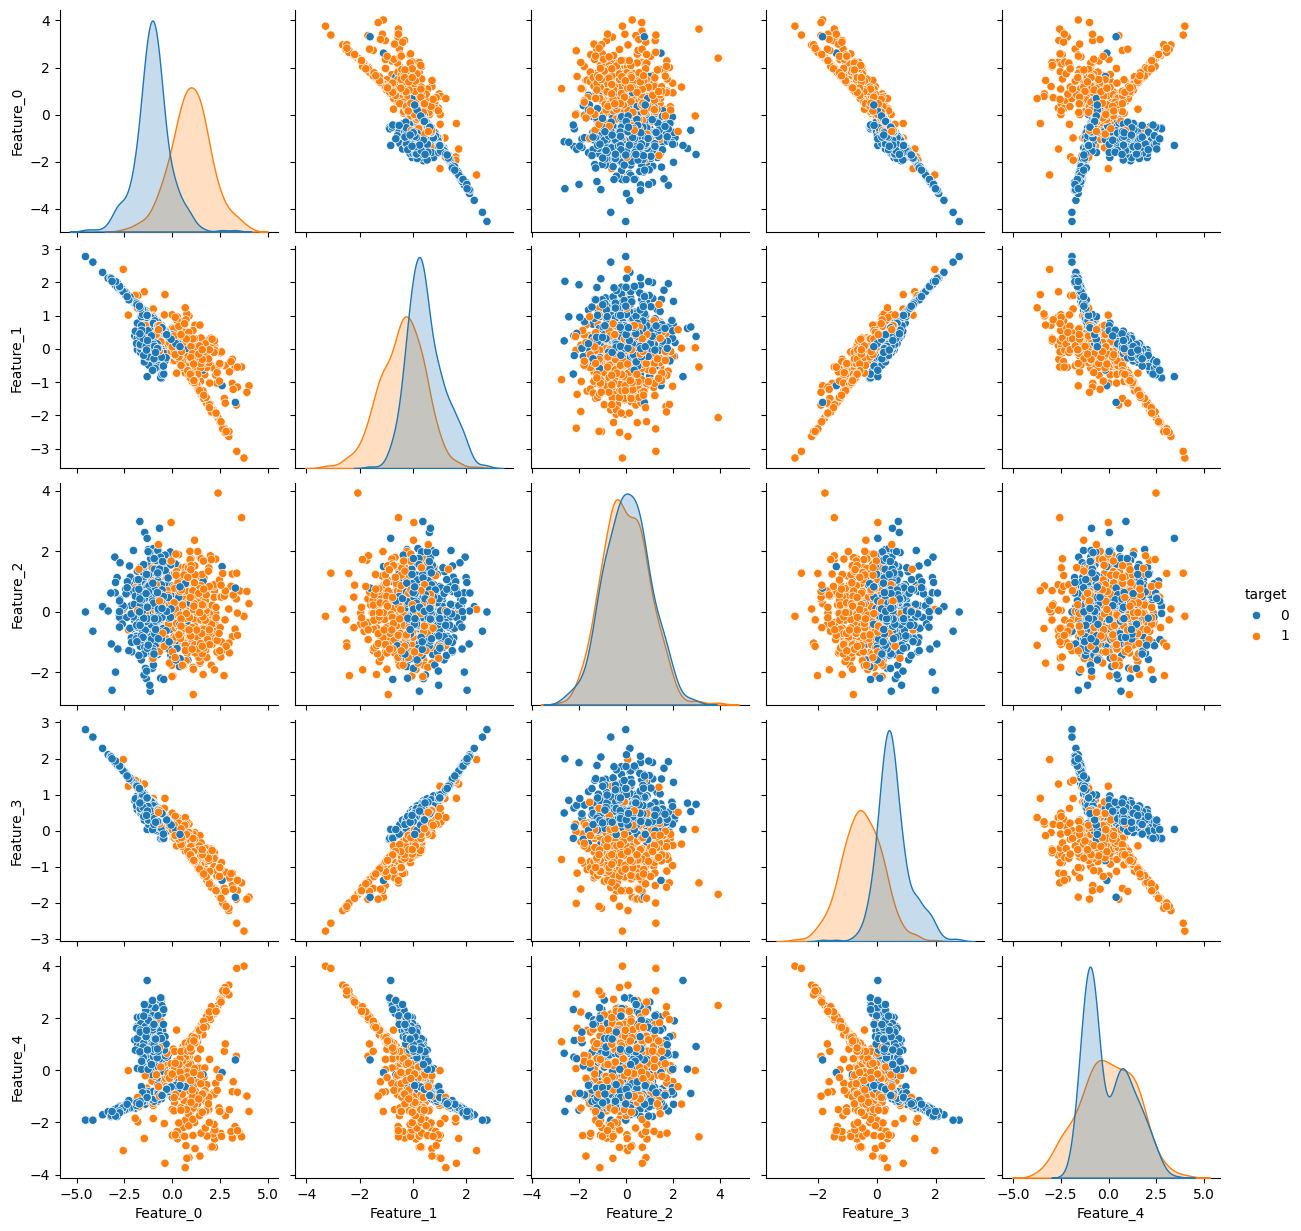

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd

# # Example data (replace this with your actual data)
# X, y = make_classification(n_samples=1000, n_features=5, random_state=42)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a classifier (replace this with your specific classifier)
# clf = RandomForestClassifier()

# # Fit the classifier on the training data
# clf.fit(X_train, y_train)

# # Combine features and target into a DataFrame
# df = pd.DataFrame(X_train, columns=[f'Feature_{i}' for i in range(X_train.shape[1])])
# df['target'] = y_train

# # Pair plot for all combinations of two features
# sns.pairplot(data=df, hue='target')
# plt.show()


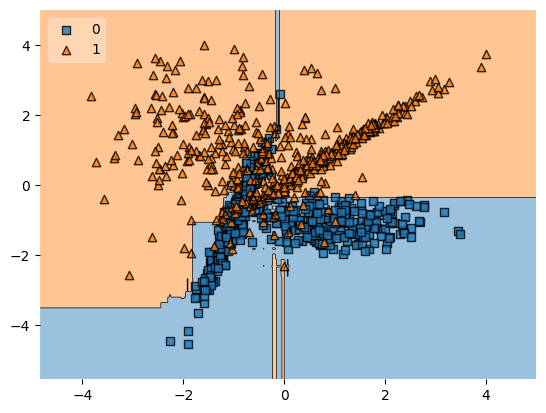

In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_decision_regions

# # Example data (replace this with your actual data)
# X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a classifier (replace this with your specific classifier)
# clf = RandomForestClassifier()

# # Train the classifier on the training data
# clf.fit(X_train, y_train)

# # Visualize decision regions if the data has two features
# if X.shape[1] == 2:
#     plot_decision_regions(X, y, clf, legend=2)
#     plt.show()


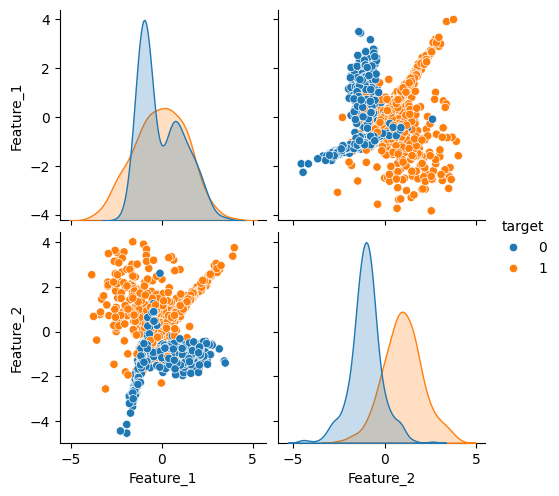

In [ ]:
# df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
# df['target'] = y  # Include target variable if available

# # Pair plot for all combinations of two features
# sns.pairplot(data=df, hue='target')
# plt.show()

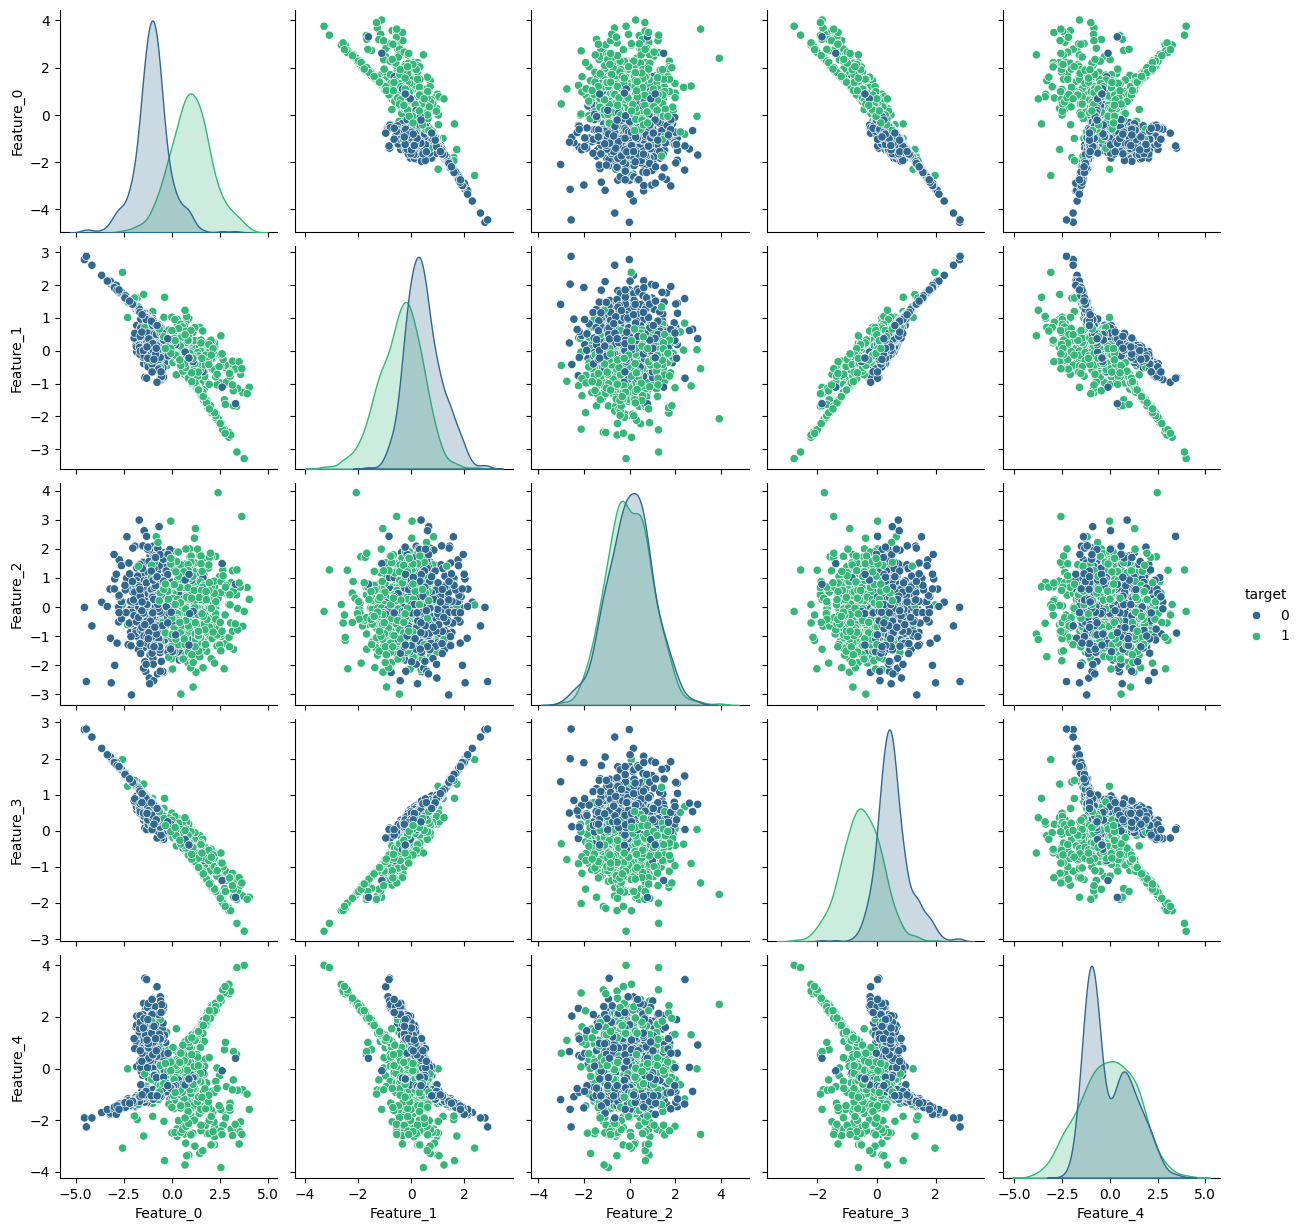

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

# # Example data (replace this with your actual data)
# X, y = make_classification(n_samples=1000, n_features=5, random_state=42)

# import seaborn as sns
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split

# # Example data (replace this with your actual data)
# X, y = make_classification(n_samples=1000, n_features=5, random_state=42)

# # Create a DataFrame with features and target variable
# df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])])
# df['target'] = y

# # Create a pair plot
# sns.pairplot(data=df, hue='target', palette='viridis')
# plt.show()

### **4. Feature selection using GA**
Use DEAP package for computational speed and easy deployment of custom evaluation functions[link text](https://)

#### 4.1. Set up the DEAP toolbox with GA operators and fitness function

In [ ]:
# # Instantiate a fitness function which maximises fitness function ('1' for maximisation)
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# # Instantiate an individual (chromosome) as a list with the fitness function defined above
# creator.create("Individual", list, fitness=creator.FitnessMax)

# # Declare size of the individual (=36 genes, one gene per feature)
# ind_size = x_train_1000.shape[1]

# # Declare the toolbox container which will contain all required operators
# toolbox = base.Toolbox()

# # Register the required operators in the toolbox

# # Register a random number generator function in the toolbox to randomly generate a 1 or 0 in each gene which flags the presence of a feature
# toolbox.register("attrib_bin", random.randint, 0, 1)

# # Register the individuals in the toolbox and insert random 0s and 1s in their 36 genes
# # initRepeat initializes the individual
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attrib_bin, n=ind_size)

# # Register a population (based on individuals defined above) in the toolbox
# # initRepeat initializes the population
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# # Define fitness function which will be applied to each individual when called
# def evaluate(individual):
#     # If all genes=0 then set fitness score to 0
#     sum_features = np.sum(individual)
#     if sum_features == 0:
#         return 0.0
#     else:
#     # Else create training and test dataframes containing selected features where gene=1 & replace missing values with 0
#         sum_features = np.sum(individual)
#         new_train = []
#         new_test = []
#         for k in range(0, len(individual)):
#             if individual[k] == 1:
#                 new_train.append(x_train_1000.iloc[:, k])
#                 new_test.append(x_test_1000.iloc[:, k])
#         x_train_1000a = np.transpose(np.array(new_train))
#         x_test_1000a = np.transpose(np.array(new_test))
#         np.nan_to_num(x_train_1000a, copy=False)
#         np.nan_to_num(y_train_1000, copy=False)
#         np.nan_to_num(x_test_1000a, copy=False)
#         np.nan_to_num(y_test_1000, copy=False)

#         # Train a LGBM classifier on feature subset
#         model=lgb.LGBMClassifier()
#         model.set_params(verbose=-1)
#         clf=model.fit(x_train_1000a, y_train_1000)

#         # Calculate fitness score for each individual in test data
#         y_pred=clf.predict_proba(x_test_1000a)[:, 1]
#         precision, recall,_=precision_recall_curve(y_test_1000, y_pred)
#         pr_auc=auc(recall,precision)

#         return (pr_auc,)

# # Register GA operators & fitness function in the DEAP toolbox

# # Selection method - tournament (size=3)
# toolbox.register("select", tools.selTournament, tournsize=3)
# # Crossover method - two point
# toolbox.register("mate", tools.cxTwoPoint)
# # Mutation - probability of any gene being flipped
# toolbox.register("mutate", tools.mutFlipBit, indpb=0.01)
# # Fitness function defined above
# toolbox.register("evaluate", evaluate)

#### 4.2 Run the GA algorithm with selected GA hyperparameters

In [ ]:
# start = time.time()

# # Set initial population size
# pop = toolbox.population(n=25) # Originally=150

# # Save fittest individual from each generation
# hof = tools.HallOfFame(1)

# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("std", np.std)
# stats.register("min", np.min)
# stats.register("avg", np.mean)
# stats.register("max", np.max)

# # Run GA algorithm with parameters:
# # pop = population size
# # toolbox = GA operators & fitness function
# # cxpb = probability of crossover of two individuals
# # mutpb = probability of mutating an individual
# # ngen = number of generations
# pop, log = algorithms.eaSimple(pop,
#                                toolbox,
#                                cxpb=0.7,
#                                mutpb=0.01,
#                                ngen=5, # Originally=25
#                                halloffame=hof,
#                                stats=stats)

# # Get the best individual
# best = hof.items[0]

# end=time.time()
# print('Run time in minutes:', (end-start)/60)

gen	nevals	std      	min     	avg     	max     
0  	25    	0.0162311	0.832553	0.867032	0.893457
1  	16    	0.0165992	0.8397  	0.87822 	0.903132
2  	16    	0.0121772	0.867279	0.895208	0.919107
3  	16    	0.00830703	0.873861	0.900295	0.913267
4  	14    	0.00582084	0.893209	0.905603	0.918826
5  	10    	0.00489588	0.899219	0.909977	0.918826
Run time in minutes: 0.5088324626286824


#### 4.3. Review outputs

['albumin', 'ast_got', 'bun', 'creatinine', 'glucose_ac', 'nitrite', 'urine_occult_blood', 'ph', 'potassium', 'sodium', 'specific_gravity', 'total_bilirubin', 'total_cholesterol', 'uric_acid', 'urine_glucose', 'urine_ketone', 'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'diabe1es', 'smoking', 'drinking', 'bee1lenu1']
No. of features selected =  24
Best fitness value =  0.9191066615130559


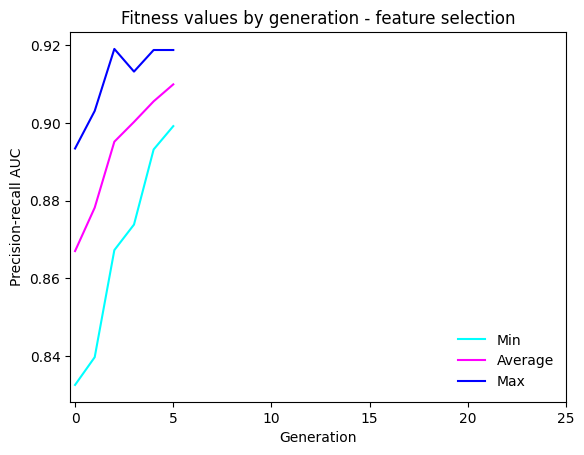

In [ ]:
# # Best individual & it's fitness score (PR-AUC)

# best_feats=[]
# for k in range(0, 36):
#     # Get feature if gene=1
#     if best[k]==1:
#         best_feats.append(x_train_1000.columns[k])
# print(best_feats)
# print("No. of features selected = ", len(best_feats))
# print("Best fitness value = ", best.fitness.values[0])

# # Plot fitness statistics per generation

# gen  = log.select("gen")
# max  = log.select("max")
# mean = log.select("avg")
# min  = log.select("min")
# evolution = pd.DataFrame({'Generation': gen,
#                           'Maximum'   : max,
#                           'Mean'      : mean,
#                           'Minimum'   : min})
# plt.title('Fitness values by generation - feature selection')
# plt.plot(evolution['Generation'], evolution['Minimum'], 'b', color = 'cyan', label = 'Min')
# plt.plot(evolution['Generation'], evolution['Mean'],    'b', color = 'magenta', label = 'Average')
# plt.plot(evolution['Generation'], evolution['Maximum'], 'b', color = 'blue', label = 'Max')
# plt.legend(loc='lower right', frameon=False)
# plt.ylabel('Precision-recall AUC')
# plt.xlabel('Generation')
# plt.xticks([0,5,10,15,20,25])
# plt.show()


#### 4.4 Build model with best feature subset by GA & default hyperparameters & evaluate


In [ ]:
# # Instantiate classifier with default hyperparameters
# model=lgb.LGBMClassifier()
# model.set_params(verbose=-1)

# # Use cross-validation to check model performance
# cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores=cross_val_score(model, x_train_1000[best_feats],y_train_1000, cv=cv, scoring=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True))
# print("Mean PR-AUC:", cv_scores.mean())

# # Train model on full training data
# clf=model.fit(x_train_1000[best_feats], y_train_1000)

# # Get prediction probabilities & class assignments (maximum probability scores) for test data
# y_pred=clf.predict_proba(x_test_1000[best_feats])[:, 1]
# y_class=clf.predict(x_test_1000[best_feats])

# # Get feature importance scores (based on gain & not split)
# feat_names=x_train_1000[best_feats].columns.tolist()
# feat_imp=clf.booster_.feature_importance(importance_type='gain')

# # Evaluate
# metrics_1000_f, feat_imp_1000_f, pr_curve_dic_1000_f, roc_curve_dic_1000_f = model_eval('_1000', y_test_1000, y_pred, y_class, feat_names, feat_imp, cv_scores.mean(), 'ss')

Mean PR-AUC: 0.9989690324288784


Compare to model using RFE feature subset selection & default hyperparamters

In [ ]:
# metrics_1000_f['method']='GA feats'

# # Load RFE data
# rfe_metrics_summary_best_model1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model1.pkl')
# metrics_1000_rfe=rfe_metrics_summary_best_model1.iloc[[-1]].drop(columns=['num_feats'])
# metrics_1000_rfe['method']='RFE feats'
# pd.concat([metrics_1000_f, metrics_1000_rfe], ignore_index=True)

tp  tn  fp  fn   logloss  accuracy    recall  precision  specificity  \
0  133  34  13  78  0.557833  0.647287  0.630332   0.910959     0.723404   
1  133  28  19  78  0.642253  0.624031  0.630332   0.875000     0.595745   

   f1_score    pr_auc   roc_auc  valid_score     method  
0  0.745098  0.919492  0.716749     0.998969   GA feats  
1  0.732782  0.877490  0.637592          NaN  RFE feats

### **5. Hyperparameter selection using GA**

#### 5.1. Set up the DEAP toolbox with GA operators and fitness function

In [ ]:
# # Instantiate a fitness function which maximises fitness function ('1' for maximisation)
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# # Instantiate an individual (chromosome) as a list with the fitness function defined above
# creator.create("Individual", list, fitness=creator.FitnessMax)

# # Declare the toolbox container which will contain all required operators
# toolbox = base.Toolbox()

# # Register the distribution of hyperparameter values for each gene in the toolbox

# # Define search grid - same as that used for randomised search
# # Remainder of hyperparameters are assumed as 'default values'
# # Presented in order a per LGBMClassifier() documentation
# lower_num_leaves,         upper_num_leaves          = 5,      60
# lower_max_depth,          upper_max_depth           = 1,      15
# lower_learning_rate,      upper_learning_rate       = 0.01,   0.15
# lower_n_estimators,       upper_n_estimators        = 80,     120
# lower_subsample_for_bin,  upper_subsample_for_bin   = 1000,   6500
# lower_min_split_gain,     upper_min_split_gain      = 0.001,  0.02
# lower_min_child_weight,   upper_min_child_weight    = 0.001,  0.005
# lower_min_child_samples,  upper_min_child_samples   = 5,      60
# lower_subsample,          upper_subsample           = 0.7,    1.0
# lower_subsample_freq,     upper_subsample_freq      = 0,      3
# lower_colsample_bytree,   upper_colsample_bytree    = 0.8,    1.0
# lower_reg_alpha,          upper_reg_alpha           = 0,      0.05
# lower_reg_lambda,         upper_reg_lambda          = 0,      0.05

# toolbox.register("attr_num_leaves",         random.randint, lower_num_leaves,         upper_num_leaves)
# toolbox.register("attr_max_depth",          random.randint, lower_max_depth,          upper_max_depth)
# toolbox.register("attr_learning_rate",      random.uniform, lower_learning_rate,      upper_learning_rate)
# toolbox.register("attr_n_estimators",       random.randint, lower_n_estimators,       upper_n_estimators)
# toolbox.register("attr_subsample_for_bin",  random.randint, lower_subsample_for_bin,  upper_subsample_for_bin)
# toolbox.register("attr_min_split_gain",     random.uniform, lower_min_split_gain,     upper_min_split_gain)
# toolbox.register("attr_min_child_weight",   random.uniform, lower_min_child_weight,   upper_min_child_weight)
# toolbox.register("attr_min_child_samples",  random.randint, lower_min_child_samples,  upper_min_child_samples)
# toolbox.register("attr_subsample",          random.uniform, lower_subsample,          upper_subsample)
# toolbox.register("attr_subsample_freq",     random.randint, lower_subsample_freq,     upper_subsample_freq)
# toolbox.register("attr_colsample_bytree",   random.uniform, lower_colsample_bytree,   upper_colsample_bytree)
# toolbox.register("attr_reg_alpha",          random.uniform, lower_reg_alpha,          upper_reg_alpha)
# toolbox.register("attr_reg_lambda",         random.uniform, lower_reg_lambda,         upper_reg_lambda)

# # Register the individuals in the toolbox and insert random values of hyperparameters for each gene
# N_CYCLES = 1
# toolbox.register("individual",
#                  tools.initCycle,
#                  creator.Individual,
#                  (toolbox.attr_num_leaves,
#                   toolbox.attr_max_depth,
#                   toolbox.attr_learning_rate,
#                   toolbox.attr_n_estimators,
#                   toolbox.attr_subsample_for_bin,
#                   toolbox.attr_min_split_gain,
#                   toolbox.attr_min_child_weight,
#                   toolbox.attr_min_child_samples,
#                   toolbox.attr_subsample,
#                   toolbox.attr_subsample_freq,
#                   toolbox.attr_colsample_bytree,
#                   toolbox.attr_reg_alpha,
#                   toolbox.attr_reg_lambda),
#                  n=N_CYCLES)

# # Register a population (based on individuals defined above) in the toolbox
# # initRepeat initializes the population
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# # Create mutation function which randomly selects a gene & randomly generates a new value for it
# def mutate(individual):

#     # Select which gene to mutate
#     gene = random.randint(0,12)

#     # Undertake mutation of selected gene
#     if gene == 0:
#       individual[0] == random.randint(lower_num_leaves, upper_num_leaves)
#     elif gene == 1:
#       individual[1] == random.randint(lower_max_depth, upper_max_depth)
#     elif gene == 2:
#       individual[2] == random.uniform(lower_learning_rate, upper_learning_rate)
#     elif gene == 3:
#       individual[3] == random.randint(lower_n_estimators, upper_n_estimators)
#     elif gene == 4:
#       individual[4] == random.randint(lower_subsample_for_bin, upper_subsample_for_bin)
#     elif gene == 5:
#       individual[5] == random.uniform(lower_min_split_gain, upper_min_split_gain)
#     elif gene == 6:
#       individual[6] == random.uniform(lower_min_child_weight, upper_min_child_weight)
#     elif gene == 7:
#       individual[7] == random.randint(lower_min_child_samples, upper_min_child_samples)
#     elif gene == 8:
#       individual[8] == random.uniform(lower_subsample, upper_subsample)
#     elif gene == 9:
#       individual[9] == random.randint(lower_subsample_freq, upper_subsample_freq)
#     elif gene == 10:
#       individual[10] == random.uniform(lower_colsample_bytree, upper_colsample_bytree)
#     elif gene == 11:
#       individual[11] == random.uniform(lower_reg_alpha, upper_reg_alpha)
#     elif gene == 12:
#       individual[12] == random.uniform(lower_reg_lambda, upper_reg_lambda)

#     return individual,

# # Create fitness function which calculates PR-AUC for the hyperparameters in an individual chromosome
# def evaluate(individual):

#     # Extract the hyperparameter values from the individual chromosome
#     num_leaves = individual[0]
#     max_depth = individual[1]
#     learning_rate = individual[2]
#     n_estimators = individual[3]
#     subsample_for_bin = individual[4]
#     min_split_gain = individual[5]
#     min_child_weight = individual[6]
#     min_child_samples = individual[7]
#     subsample = individual[8]
#     subsample_freq = individual[9]
#     colsample_bytree = individual[10]
#     reg_alpha = individual[11]
#     reg_lambda = individual[12]

#     model=lgb.LGBMClassifier(num_leaves=num_leaves,
#                              max_depth=max_depth,
#                              learning_rate=learning_rate,
#                              n_estimators=n_estimators,
#                              subsample_for_bin=subsample_for_bin,
#                              min_split_gain=min_split_gain,
#                              min_child_weight=min_child_weight,
#                              min_child_samples=min_child_samples,
#                              subsample=subsample,
#                              subsample_freq=subsample_freq,
#                              colsample_bytree=colsample_bytree,
#                              reg_alpha=reg_alpha,
#                              reg_lambda=reg_lambda)

#     model.set_params(verbose=-1)
#     clf=model.fit(x_train_1000[best_feats], y_train_1000)

#     # Get prediction probabilities & calculate fitness (PR-AUC) for individual chromosome in test samples
#     y_pred=clf.predict_proba(x_test_1000[best_feats])[:, 1]
#     precision, recall,_=precision_recall_curve(y_test_1000, y_pred)
#     pr_auc=auc(recall,precision)

#     return pr_auc,

# # Register GA operators and fitness function with toolbox
# toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("mate", tools.cxOnePoint)
# toolbox.register("mutate",mutate)
# toolbox.register("evaluate", evaluate)

#### 5.2. Run the GA algorithm with selected GA hyperparameters

In [ ]:
# start = time.time()

# # Set GA hyperparameters
# population_size = 25 # Originally=300
# crossover_probability = 0.7
# mutation_probability = 0.04
# number_of_generations = 5 # Originally=20

# # Set initial population size
# pop = toolbox.population(n=population_size)

# # Collect best performing individual per generation
# hof = tools.HallOfFame(1)

# # Set up fitness function statistics collection
# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("avg", np.mean)
# stats.register("std", np.std)
# stats.register("min", np.min)
# stats.register("max", np.max)

# # Run the algorithm
# pop, log = algorithms.eaSimple(pop,
#                                toolbox,
#                                cxpb=crossover_probability,
#                                stats = stats,
#                                mutpb = mutation_probability,
#                                ngen=number_of_generations,
#                                halloffame=hof,
#                                verbose=True)

# # Save the optimal set of of hyperparameters
# best_parameters = hof[0]

# end=time.time()
# print('Run time in minutes:', (end-start)/60)

gen	nevals	avg     	std      	min     	max     
0  	25    	0.905344	0.0100283	0.886583	0.922952
1  	20    	0.912823	0.00669122	0.898816	0.922952
2  	15    	0.914202	0.0075763 	0.89735 	0.922952
3  	15    	0.91682 	0.00669234	0.901173	0.922952
4  	18    	0.918429	0.00670138	0.901173	0.922879
5  	14    	0.922628	0.00123064	0.916599	0.922879
Run time in minutes: 0.3961410880088806


#### 5.3. Review outputs

Best hyperparameter values =  {'num_leaves': 28, 'max_depth': 15, 'learning_rate': 0.13865690996770727, 'n_estimators': 104, 'subsample_for_bin': 1687, 'min_split_gain': 0.010561741773658897, 'min_child_weight': 0.0036749432344135927, 'min_child_samples': 38, 'subsample': 0.8755067013311022, 'subsample_freq': 1, 'colsample_bytree': 0.8099579315193361, 'reg_alpha': 0.026494193478283013, 'reg_lambda': 0.047174391326178955}
Best fitness value =  0.9229517977479403


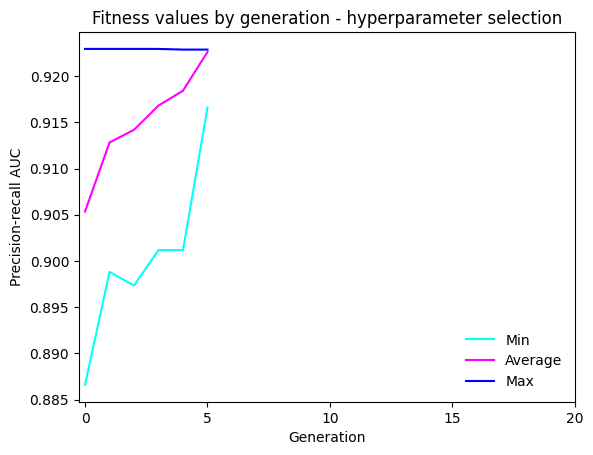

In [ ]:
# # Best individual & it's fitness score (PR-AUC)

# hyper_names=['num_leaves','max_depth','learning_rate','n_estimators','subsample_for_bin','min_split_gain','min_child_weight','min_child_samples','subsample','subsample_freq','colsample_bytree','reg_alpha','reg_lambda']
# hypers=dict(zip(hyper_names,best_parameters))
# print("Best hyperparameter values = ", hypers)
# print("Best fitness value = ", best_parameters.fitness.values[0])

# # Plot fitness statistics per generation

# gen  = log.select("gen")
# max  = log.select("max")
# mean = log.select("avg")
# min  = log.select("min")
# evolution = pd.DataFrame({'Generation': gen,
#                           'Maximum'   : max,
#                           'Mean'      : mean,
#                           'Minimum'   : min})
# plt.title('Fitness values by generation - hyperparameter selection')
# plt.plot(evolution['Generation'], evolution['Minimum'], 'b', color = 'cyan', label = 'Min')
# plt.plot(evolution['Generation'], evolution['Mean'],    'b', color = 'magenta', label = 'Average')
# plt.plot(evolution['Generation'], evolution['Maximum'], 'b', color = 'blue', label = 'Max')
# plt.legend(loc='lower right', frameon=False)
# plt.ylabel('Precision-recall AUC')
# plt.xlabel('Generation')
# plt.xticks([0,5,10,15,20])
# plt.show()


#### 5.4 Build model with best feature subset & hyperparameters generated by GA & evaluate


In [ ]:
# # Instantiate classifier with best hyperparameters
# model=lgb.LGBMClassifier(**hypers)
# model.set_params(verbose=-1)

# # Use cross-validation to check model performance
# cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores=cross_val_score(model, x_train_1000[best_feats],y_train_1000, cv=cv, scoring=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True))
# print("Mean PR-AUC:", cv_scores.mean())

# # Train model on full training data
# clf=model.fit(x_train_1000[best_feats], y_train_1000)

# # Get prediction probabilities & class assignments (maximum probability scores) for test data
# y_pred=clf.predict_proba(x_test_1000[best_feats])[:, 1]
# y_class=clf.predict(x_test_1000[best_feats])

# # Get feature importance scores (based on gain & not split)
# feat_names=x_train_1000[best_feats].columns.tolist()
# feat_imp=clf.booster_.feature_importance(importance_type='gain')

# # Evaluate
# metrics_1000_f_h, feat_imp_1000_f_h, pr_curve_dic_1000_f_h, roc_curve_dic_1000_f_h = model_eval('_1000', y_test_1000, y_pred, y_class, feat_names, feat_imp, 0, 'ss')

Mean PR-AUC: 0.998998859671785


Compare to model using best feature subset selected with GA and default hyperparameters


In [ ]:
# metrics_1000_f_h['method']='GA hypers & feats'
# metrics_1000_f['method']  ='GA feats'
# pd.concat([metrics_1000_f_h, metrics_1000_f], ignore_index=True)

tp  tn  fp  fn   logloss  accuracy    recall  precision  specificity  \
0  144  32  15  67  0.520918  0.682171  0.682464   0.905660     0.680851   
1  133  34  13  78  0.557833  0.647287  0.630332   0.910959     0.723404   

   f1_score    pr_auc   roc_auc  valid_score             method  
0  0.778378  0.923287  0.736916     0.000000  GA hypers & feats  
1  0.745098  0.919492  0.716749     0.998969           GA feats